In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam

import os
import time
import math
import numpy as np
import skimage.io as io
from torchsummary import summary

from di_dataset2 import DepthImageDataset, collate_batch

2022-03-02 18:56:58.383908: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/patricknit/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Hyperparams

In [3]:
latent_dim = 64
num_epochs = 10
batch_size = 32
learning_rate = 1e-3

save_model = True
load_model = False

# Load Dataset

In [4]:
tfrecord_folder='../../../rl_data/tfrecord'
tfrecord_test_folder='../../../rl_data/tfrecord/test'

In [5]:
train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size) # 176 tfrecords
test_dataset = DepthImageDataset(tfrecord_folder=tfrecord_test_folder, batch_size=batch_size) # 20 tfrecords

Loading tfrecords...
['../../../rl_data/tfrecord/data102.tfrecords']
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-03-02 18:56:59.157328: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-02 18:56:59.158042: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-02 18:56:59.159632: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-02 18:56:59.159645: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (patricknit-OptiPlex-7060): /proc/driver/nvidia/version does not exist
2022-03-02 18:56:59.159822: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate co

Iterating length...
Done.
Loading tfrecords...
['../../../rl_data/tfrecord/test/data183.tfrecords']
Iterating length...
Done.


In [6]:
len_train_dataset = len(train_dataset)
len_test_dataset = len(test_dataset)
n_training_samples = len_train_dataset * 32 # 32 samples per batch
print(len_train_dataset, len_test_dataset)
n_training_samples

65 70


2080

In [7]:
train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, collate_fn=collate_batch)

In [8]:
dataiter = iter(train_loader)
image_batch, *_ = dataiter.next() # image, height, width, depth
image_batch.shape

gotcha


torch.Size([32, 1, 270, 480])

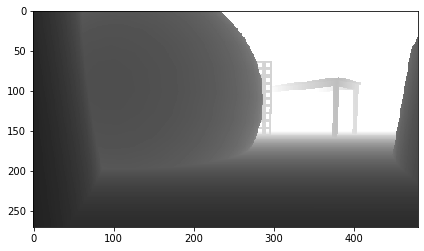

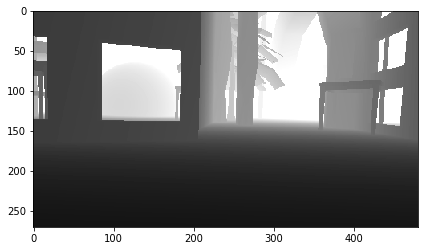

/home/patricknit/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


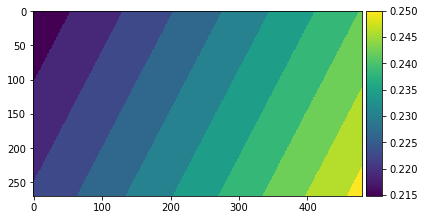

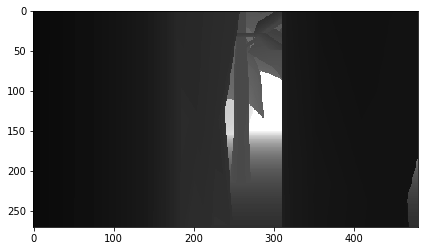

torch.Size([1, 270, 480])

In [9]:
def imshow(image):
    io.imshow(image.squeeze().numpy())
    io.show()

for image in image_batch[0:4]:
    imshow(image)
    
image.shape

In [10]:
image_batch.squeeze().mean(), image_batch.squeeze().var()

(tensor(0.4479), tensor(0.1177))

# Define Variational Autoencoder

Adapted from https://github.com/microsoft/AirSim-Drone-Racing-VAE-Imitation/blob/master/racing_models/cmvae.py

### Dronet
ResNet8 as encoder.

In [11]:
image_batch, *_ = dataiter.next()

In [12]:
class Dronet(nn.Module):
    def __init__(self, input_dim, num_outputs, include_top=True):
        super(Dronet, self).__init__()
        self.include_top = include_top
        
        print('[Dronet] Starting dronet')

        self.max0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # default pool_size='2', strides=2

        self.bn0 = nn.BatchNorm2d(32)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)

        self.conv0 = nn.Conv2d(input_dim, 32, kernel_size=5, stride=2, padding=2)
        self.xavier_uniform_init(self.conv0)
        
        self.conv0_2 = nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=2)

        self.conv1 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1) # padding='same' 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1) # padding='same' # Todo: kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=1, stride=2)
        self.xavier_uniform_init(self.conv3)

        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) # padding='same' # Todo: kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1) # padding='same' # Todo: kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        self.conv6 = nn.Conv2d(32, 64, kernel_size=1, stride=2) # padding='same'
        self.xavier_uniform_init(self.conv6)

        self.conv7 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) # padding='same' # Todo: kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        self.conv8 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # padding='same' # Todo: kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        self.conv9 = nn.Conv2d(64, 128, kernel_size=1, stride=2) # padding='same'
        self.xavier_uniform_init(self.conv9)

        self.dense0 = nn.Linear(9*15*128, 64) # Todo: check size
        self.dense1 = nn.Linear(64, 32)
        self.dense2 = nn.Linear(32, num_outputs)
        self.dense3 = nn.Linear(9*15*128, num_outputs)

        print('[Dronet] Done with dronet')
    
    
    def xavier_uniform_init(self, m):
        """
        Default initialisation in Keras is glorot_uniform == xavier_uniform in Pytorch

        https://discuss.pytorch.org/t/crossentropyloss-expected-object-of-type-torch-longtensor/28683/6?u=ptrblck
        https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
        """
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('linear')) # gain=nn.init.calculate_gain('relu')
            nn.init.zeros_(m.bias)
        return m

    def forward(self, img):
        # Input
        
        #print(img.shape)
        print(f"- Before encoding, mean: {img.mean():.3f} var: {img.var():.3f}")
        x1 = self.conv0(img)
        #print("x1:", x1.shape)
        #x1, indices = self.max0(x1)
        x1 = self.conv0_2(x1)
        #print("x1:", x1.shape)

        # First residual block
        x2 = self.bn0(x1)
        #print("x2:", x2.shape)
        # x2 = x1
        x2 = torch.relu(x2)
        #print(x2.shape)
        x2 = self.conv1(x2)
        #print(x2.shape)

        x2 = self.bn1(x2)
        #print(x2.shape)
        x2 = torch.relu(x2)
        #print(x2.shape)
        x2 = self.conv2(x2)
        #print(x2.shape)
        
        
        x1 = self.conv3(x1)
        #print(f"x1: {x1.shape}, x2: {x2.shape}") # 32, 34, 60
        x3 = x1+x2
        #print("x3:", x3.shape)

        # Second residual block
        x4 = self.bn2(x3)
        #print("x4:", x4.shape)
        # x4 = x3
        x4 = torch.relu(x4)
        x4 = self.conv4(x4)
        #print(x4.shape)

        x4 = self.bn3(x4)
        #print(x4.shape)
        x4 = torch.relu(x4)
        x4 = self.conv5(x4)
        #print(x4.shape)
        
        x3 = self.conv6(x3)
        #print(f"x3: {x3.shape}, x4: {x4.shape}")
        x5 = x3+x4 # 34, 60, 64

        # Third residual block
        x6 = self.bn4(x5)
        # x6 = x5
        x6 = torch.relu(x6)
        x6 = self.conv7(x6)

        x6 = self.bn5(x6)
        x6 = torch.relu(x6)
        x6 = self.conv8(x6)

        x5 = self.conv9(x5)
        #print(f"x5: {x5.shape}, x6: {x6.shape}")
        x7 = x5+x6 # 17, 30, 128

        x = x7.view(x7.size(0), -1)
        #print(f"x before linear: {x.shape}")
        #print(f"- After encoding, mean: {x.mean():.3f} var: {x.var():.3f}")

        if self.include_top:
            x = torch.relu(x)
            # x = tf.keras.layers.Dropout(0.5)(x)
            x = self.dense0(x)
            x = self.dense1(x)
            #gate_pose = self.dense2(x)
            x_enc = self.dense2(x)
            # phi_rel = self.dense_phi_rel(x)
            # gate_pose = tf.concat([gate_pose, phi_rel], 1)
            #print(f"x_enc: {x.shape}")
            return x_enc
        else:
            x = self.dense3(x)
            #print(f"x_enc: {x.shape}")
            return x

dronet = Dronet(input_dim=1, num_outputs=latent_dim*2, include_top=True)
summary(dronet, input_size=(1, 270, 480), batch_size=-1, device=device.type)

[Dronet] Starting dronet
[Dronet] Done with dronet
- Before encoding, mean: 0.500 var: 0.083
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 135, 240]             832
            Conv2d-2          [-1, 32, 68, 120]          25,632
       BatchNorm2d-3          [-1, 32, 68, 120]              64
            Conv2d-4           [-1, 32, 34, 60]           9,248
       BatchNorm2d-5           [-1, 32, 34, 60]              64
            Conv2d-6           [-1, 32, 34, 60]           9,248
            Conv2d-7           [-1, 32, 34, 60]           1,056
       BatchNorm2d-8           [-1, 32, 34, 60]              64
            Conv2d-9           [-1, 64, 17, 30]          18,496
      BatchNorm2d-10           [-1, 64, 17, 30]             128
           Conv2d-11           [-1, 64, 17, 30]          36,928
           Conv2d-12           [-1, 64, 17, 30]           2,112
      Batc

### Decoder

In [13]:
class ImgDecoder(nn.Module):
    def __init__(self, input_dim=100, batch=32):
        super(ImgDecoder, self).__init__()
        print('[ImgDecoder] Starting create_model')
        self.dense = nn.Linear(input_dim, 9*15*128)
        
        self.bn0 = nn.BatchNorm2d(128)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.deconv1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=(2,2), output_padding=(0,1), dilation=1)
        self.deconv3 = nn.ConvTranspose2d(64, 64, kernel_size=6, stride=2, padding=(2,2), output_padding=(0,0), dilation=1)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2, padding=(2,2), output_padding=(0,0), dilation=1)
        self.deconv5 = nn.ConvTranspose2d(32, 32, kernel_size=5, stride=2, padding=(2,2), output_padding=(0,1), dilation=1)
        self.deconv6 = nn.ConvTranspose2d(32, 16, kernel_size=6, stride=2, padding=(2,2), output_padding=(0,0))
        self.deconv7 = nn.ConvTranspose2d(16, 1, kernel_size=5, stride=1, padding=2) # tanh activation or sigmoid

        print('[ImgDecoder] Done with create_model')

    def forward(self, z):
        #print("z: ", z.shape)
        x = self.dense(z)
        #print(x.shape)
        x = x.view(x.size(0), 128, 9, 15)
        #print(f"- Before deconv, mean: {x.mean():.3f} var: {x.var():.3f}")
        x = self.deconv1(x)
        x = torch.relu(x)
        #print("after deconv1", x.shape)
        x = self.deconv2(x)
        x = torch.relu(x)
        #print("after deconv2", x.shape)
        x = self.deconv3(x)
        x = torch.relu(x)
#         print("after deconv3", x.shape)
        x = self.deconv4(x)
        x = torch.relu(x)
#         print("after deconv4", x.shape)
        x = self.deconv5(x)
        #print("indices", indices.shape)
        #x = self.unpool(x, indices, output_size=(x.size(0), 1, 135, 240))
#         print("after deconv5", x.shape)
        x = torch.relu(x)
        #print("after unpool", x.shape)
        x = self.deconv6(x)
        x = torch.relu(x)
#         print("after deconv6", x.shape)
        x = self.deconv7(x)
        print(f"- After deconv 7, mean: {x.mean():.3f} var: {x.var():.3f}")
        x = torch.sigmoid(x)
        print(f"- After sigmoid, mean: {x.mean():.3f} var: {x.var():.3f}")
        #print("after deconv7", x.shape)
        return x

img_decoder = ImgDecoder(input_dim=latent_dim, batch=1)
summary(img_decoder, (1,latent_dim))

[ImgDecoder] Starting create_model
[ImgDecoder] Done with create_model
- After deconv 7, mean: -0.004 var: 0.000
- After sigmoid, mean: 0.499 var: 0.000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1, 17280]       1,123,200
   ConvTranspose2d-2           [-1, 128, 9, 15]         147,584
   ConvTranspose2d-3           [-1, 64, 17, 30]         204,864
   ConvTranspose2d-4           [-1, 64, 34, 60]         147,520
   ConvTranspose2d-5          [-1, 32, 68, 120]          73,760
   ConvTranspose2d-6         [-1, 32, 135, 240]          25,632
   ConvTranspose2d-7         [-1, 16, 270, 480]          18,448
   ConvTranspose2d-8          [-1, 1, 270, 480]             401
Total params: 1,741,409
Trainable params: 1,741,409
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 28.22
Para

## VAE

In [14]:
class Lambda(nn.Module):
    def __init__(self, func):
        super(Lambda, self).__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
        

class VAE(nn.Module):
    def __init__(self, n_z):
        super(VAE, self).__init__()
        
        # create the 3 base models:
        self.q_img = Dronet(input_dim=1, num_outputs=n_z*2, include_top=True)
        self.p_img = ImgDecoder(input_dim=n_z)
        
        # Create sampler
        self.mean_params = Lambda(lambda x: x[:, :n_z])
        self.logvar_params = Lambda(lambda x: x[:, n_z:])

    def forward(self, x):
        # Possible modes for reconstruction:
        # img -> img

        x = self.q_img(x)
        
        means = self.mean_params(x)
        logvar = self.logvar_params(x)
        stddev = torch.exp(0.5 * logvar)
        eps = torch.randn_like(stddev)
        z = means + eps * stddev
        #print(z.shape)
        #print("OK")
        img_recon = self.p_img(z)
        
        return img_recon, means, logvar, z
    
    def forward_test(self, x):
        x = self.q_img(x)
        
        means = self.mean_params(x)
        logvar = self.logvar_params(x)
        stddev = torch.exp(0.5 * logvar)
        eps = torch.zeros_like(stddev)
        z = means + eps * stddev
        #print(z.shape)
        #print("OK")
        img_recon = self.p_img(z)
        return img_recon, means, logvar, z
        

    def encode(self, x):
        x = self.q_img(x)
        means = self.mean_params(x)
        stddev = torch.exp(0.5 * self.stddev_params(x))
        eps = torch.randn_like(stddev)
        z = means + eps * stddev
        return z, means, stddev

    def decode(self, z, mode):
        # Possible modes for reconstruction:
        # z -> img
        img_recon = self.p_img(z)
        return img_recon


### Define Model

In [15]:
vae_model = VAE(n_z=latent_dim)

if load_model:
    vae_model.load_state_dict(torch.load(load_model_file))
    vae_model.eval()
else:
    vae_model.train()

optimiser = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)
summary(vae_model, (1, 270, 480))

[Dronet] Starting dronet
[Dronet] Done with dronet
[ImgDecoder] Starting create_model
[ImgDecoder] Done with create_model
- Before encoding, mean: 0.499 var: 0.083
- After deconv 7, mean: 0.159 var: 0.000
- After sigmoid, mean: 0.540 var: 0.000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 135, 240]             832
            Conv2d-2          [-1, 32, 68, 120]          25,632
       BatchNorm2d-3          [-1, 32, 68, 120]              64
            Conv2d-4           [-1, 32, 34, 60]           9,248
       BatchNorm2d-5           [-1, 32, 34, 60]              64
            Conv2d-6           [-1, 32, 34, 60]           9,248
            Conv2d-7           [-1, 32, 34, 60]           1,056
       BatchNorm2d-8           [-1, 32, 34, 60]              64
            Conv2d-9           [-1, 64, 17, 30]          18,496
      BatchNorm2d-10           [-1, 64, 17, 30]   

# Training

In [16]:
def BCELoss(x, x_hat, mean, log_var):
    reproduction_loss = nn.BCELoss(reduction='sum')(x_hat, x)
    KLD      = 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss - KLD

def mse_loss(x, x_hat, mu, logvar):
    #rep = (x_hat - x)**2
    reproduction_loss = F.mse_loss(x_hat, x, reduction="sum")
    kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reproduction_loss - kl_divergence

gotcha
- Before encoding, mean: 0.445 var: 0.119
- After deconv 7, mean: 0.159 var: 0.000
- After sigmoid, mean: 0.540 var: 0.000
Epoch: 1/10, Step: 1/65, Avg loss: 16531.570, time: 4.51, Avg. per iter 4.34, Est. time left 277.57

- Before encoding, mean: 0.499 var: 0.130
- After deconv 7, mean: 0.141 var: 0.000
- After sigmoid, mean: 0.535 var: 0.000
Epoch: 1/10, Step: 2/65, Avg loss: 16848.068, time: 8.88, Avg. per iter 4.35, Est. time left 274.29

- Before encoding, mean: 0.460 var: 0.129
- After deconv 7, mean: 0.129 var: 0.000
- After sigmoid, mean: 0.532 var: 0.000
Epoch: 1/10, Step: 3/65, Avg loss: 17053.514, time: 13.49, Avg. per iter 4.44, Est. time left 275.08

- Before encoding, mean: 0.452 var: 0.125
- After deconv 7, mean: 0.112 var: 0.000
- After sigmoid, mean: 0.528 var: 0.000
Epoch: 1/10, Step: 4/65, Avg loss: 17033.137, time: 18.19, Avg. per iter 4.50, Est. time left 274.72

- Before encoding, mean: 0.392 var: 0.093
- After deconv 7, mean: 0.088 var: 0.000
- After sigm

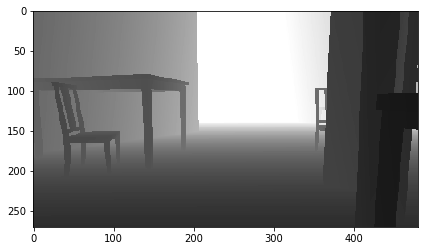

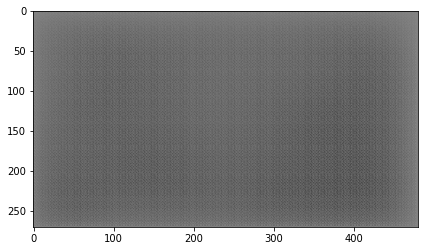

- Before encoding, mean: 0.419 var: 0.094
- After deconv 7, mean: -0.227 var: 0.056
- After sigmoid, mean: 0.445 var: 0.003
Epoch: 1/10, Step: 11/65, Avg loss: 17914.863, time: 49.82, Avg. per iter 4.49, Est. time left 242.67

- Before encoding, mean: 0.469 var: 0.102
- After deconv 7, mean: -0.139 var: 0.018
- After sigmoid, mean: 0.465 var: 0.001
Epoch: 1/10, Step: 12/65, Avg loss: 17479.170, time: 54.24, Avg. per iter 4.49, Est. time left 237.86

- Before encoding, mean: 0.476 var: 0.108
- After deconv 7, mean: -0.158 var: 0.021
- After sigmoid, mean: 0.461 var: 0.001
Epoch: 1/10, Step: 13/65, Avg loss: 17175.453, time: 58.54, Avg. per iter 4.47, Est. time left 232.61

- Before encoding, mean: 0.481 var: 0.106
- After deconv 7, mean: -0.184 var: 0.029
- After sigmoid, mean: 0.455 var: 0.002
Epoch: 1/10, Step: 14/65, Avg loss: 16899.830, time: 63.81, Avg. per iter 4.53, Est. time left 231.03

- Before encoding, mean: 0.433 var: 0.109
- After deconv 7, mean: -0.195 var: 0.029
- After 

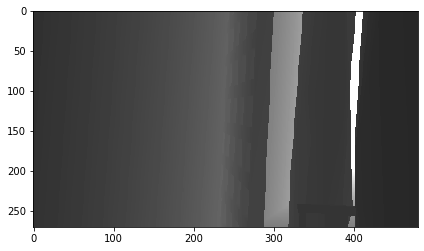

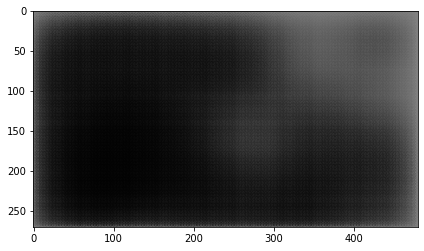

- Before encoding, mean: 0.489 var: 0.122
- After deconv 7, mean: -2.079 var: 14.161
- After sigmoid, mean: 0.345 var: 0.047
Epoch: 1/10, Step: 21/65, Avg loss: 15196.429, time: 94.48, Avg. per iter 4.47, Est. time left 196.72

- Before encoding, mean: 0.547 var: 0.123
- After deconv 7, mean: -0.597 var: 2.260
- After sigmoid, mean: 0.421 var: 0.026
Epoch: 1/10, Step: 22/65, Avg loss: 15183.031, time: 98.90, Avg. per iter 4.47, Est. time left 192.15

- Before encoding, mean: 0.419 var: 0.106
- After deconv 7, mean: -0.637 var: 3.565
- After sigmoid, mean: 0.431 var: 0.025
Epoch: 1/10, Step: 23/65, Avg loss: 14990.720, time: 103.24, Avg. per iter 4.46, Est. time left 187.43

- Before encoding, mean: 0.446 var: 0.100
- After deconv 7, mean: -0.666 var: 4.029
- After sigmoid, mean: 0.429 var: 0.026
Epoch: 1/10, Step: 24/65, Avg loss: 14804.308, time: 107.74, Avg. per iter 4.46, Est. time left 183.04

- Before encoding, mean: 0.477 var: 0.109
- After deconv 7, mean: -0.866 var: 5.332
- Aft

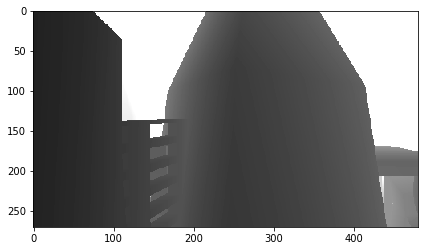

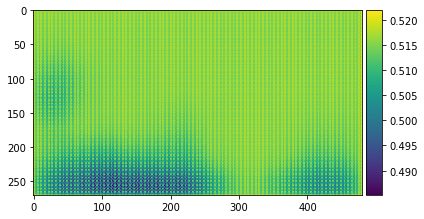

- Before encoding, mean: 0.487 var: 0.123
- After deconv 7, mean: -0.421 var: 0.901
- After sigmoid, mean: 0.427 var: 0.021
Epoch: 1/10, Step: 31/65, Avg loss: 14177.152, time: 138.66, Avg. per iter 4.45, Est. time left 151.17

- Before encoding, mean: 0.394 var: 0.106
- After deconv 7, mean: -0.738 var: 1.638
- After sigmoid, mean: 0.379 var: 0.028
Epoch: 1/10, Step: 32/65, Avg loss: 14010.942, time: 143.19, Avg. per iter 4.45, Est. time left 146.80

- Before encoding, mean: 0.411 var: 0.110
- After deconv 7, mean: -1.933 var: 7.137
- After sigmoid, mean: 0.286 var: 0.045
Epoch: 1/10, Step: 33/65, Avg loss: 13871.854, time: 147.67, Avg. per iter 4.45, Est. time left 142.39

- Before encoding, mean: 0.473 var: 0.137
- After deconv 7, mean: -2.244 var: 7.819
- After sigmoid, mean: 0.256 var: 0.045
Epoch: 1/10, Step: 34/65, Avg loss: 13903.686, time: 152.04, Avg. per iter 4.45, Est. time left 137.86

- Before encoding, mean: 0.407 var: 0.097
- After deconv 7, mean: -1.677 var: 5.222
- Af

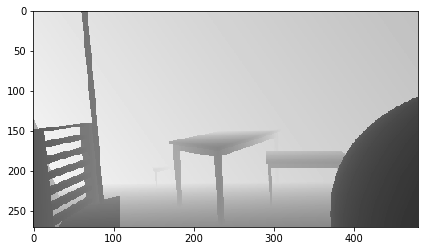

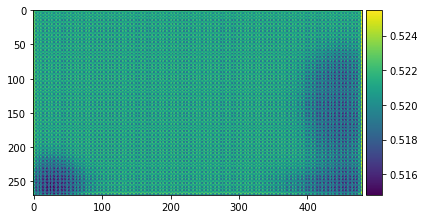

- Before encoding, mean: 0.457 var: 0.102
- After deconv 7, mean: -0.483 var: 0.951
- After sigmoid, mean: 0.415 var: 0.026
Epoch: 1/10, Step: 41/65, Avg loss: 13131.526, time: 182.93, Avg. per iter 4.44, Est. time left 106.46

- Before encoding, mean: 0.445 var: 0.117
- After deconv 7, mean: -0.638 var: 1.372
- After sigmoid, mean: 0.395 var: 0.032
Epoch: 1/10, Step: 42/65, Avg loss: 13068.488, time: 187.17, Avg. per iter 4.43, Est. time left 101.92

- Before encoding, mean: 0.453 var: 0.101
- After deconv 7, mean: -0.802 var: 2.012
- After sigmoid, mean: 0.379 var: 0.035
Epoch: 1/10, Step: 43/65, Avg loss: 12979.488, time: 191.45, Avg. per iter 4.43, Est. time left 97.40

- Before encoding, mean: 0.393 var: 0.093
- After deconv 7, mean: -1.045 var: 2.948
- After sigmoid, mean: 0.356 var: 0.038
Epoch: 1/10, Step: 44/65, Avg loss: 12856.340, time: 196.11, Avg. per iter 4.43, Est. time left 93.09

- Before encoding, mean: 0.468 var: 0.115
- After deconv 7, mean: -1.289 var: 3.689
- Afte

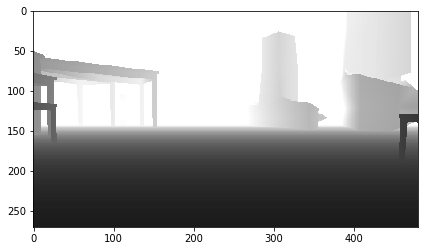

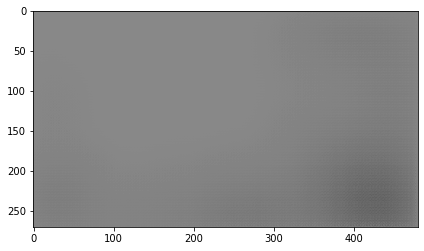

- Before encoding, mean: 0.445 var: 0.123
- After deconv 7, mean: -0.715 var: 1.151
- After sigmoid, mean: 0.371 var: 0.032
Epoch: 1/10, Step: 51/65, Avg loss: 12292.543, time: 227.16, Avg. per iter 4.43, Est. time left 62.01

- Before encoding, mean: 0.464 var: 0.106
- After deconv 7, mean: -0.928 var: 1.691
- After sigmoid, mean: 0.345 var: 0.036
Epoch: 1/10, Step: 52/65, Avg loss: 12229.285, time: 231.38, Avg. per iter 4.43, Est. time left 57.53

- Before encoding, mean: 0.461 var: 0.106
- After deconv 7, mean: -0.997 var: 1.778
- After sigmoid, mean: 0.336 var: 0.037
Epoch: 1/10, Step: 53/65, Avg loss: 12168.443, time: 235.70, Avg. per iter 4.42, Est. time left 53.08

- Before encoding, mean: 0.442 var: 0.105
- After deconv 7, mean: -0.692 var: 0.864
- After sigmoid, mean: 0.365 var: 0.028
Epoch: 1/10, Step: 54/65, Avg loss: 12114.224, time: 239.94, Avg. per iter 4.42, Est. time left 48.62

- Before encoding, mean: 0.368 var: 0.097
- After deconv 7, mean: -0.534 var: 0.675
- After 

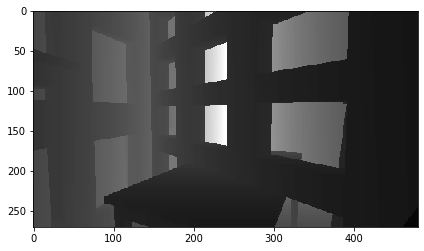

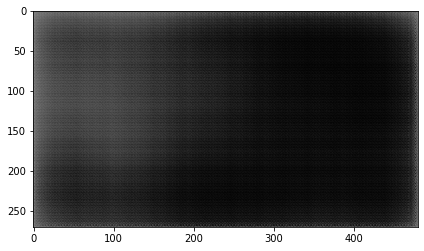

- Before encoding, mean: 0.419 var: 0.095
- After deconv 7, mean: -0.995 var: 1.719
- After sigmoid, mean: 0.334 var: 0.038
Epoch: 1/10, Step: 61/65, Avg loss: 11665.588, time: 271.30, Avg. per iter 4.42, Est. time left 17.69

- Before encoding, mean: 0.471 var: 0.120
- After deconv 7, mean: -0.553 var: 0.815
- After sigmoid, mean: 0.393 var: 0.028
Epoch: 1/10, Step: 62/65, Avg loss: 11631.762, time: 275.97, Avg. per iter 4.43, Est. time left 13.28

- Before encoding, mean: 0.435 var: 0.104
- After deconv 7, mean: -0.332 var: 0.377
- After sigmoid, mean: 0.428 var: 0.018
Epoch: 1/10, Step: 63/65, Avg loss: 11574.705, time: 280.27, Avg. per iter 4.43, Est. time left 8.85

- Before encoding, mean: 0.402 var: 0.102
- After deconv 7, mean: -0.363 var: 0.409
- After sigmoid, mean: 0.421 var: 0.019
Epoch: 1/10, Step: 64/65, Avg loss: 11522.223, time: 284.68, Avg. per iter 4.43, Est. time left 4.43

- Before encoding, mean: 0.449 var: 0.106
- After deconv 7, mean: -0.595 var: 0.959
- After si

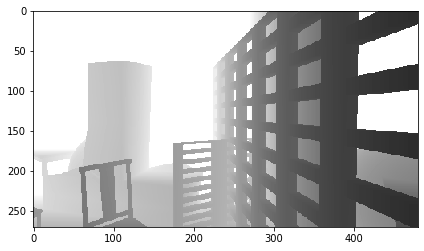

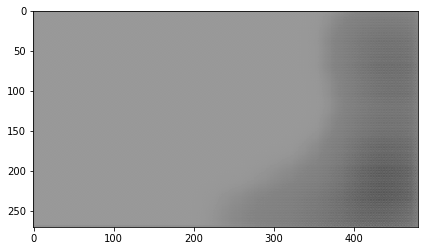

- Before encoding, mean: 0.425 var: 0.096
- After deconv 7, mean: -2.102 var: 9.415
- After sigmoid, mean: 0.307 var: 0.064
Epoch: 2/10, Step: 11/65, Avg loss: 8280.308, time: 45.70, Avg. per iter 4.36, Est. time left 235.39

- Before encoding, mean: 0.473 var: 0.110
- After deconv 7, mean: -2.081 var: 10.380
- After sigmoid, mean: 0.330 var: 0.069
Epoch: 2/10, Step: 12/65, Avg loss: 8255.567, time: 49.75, Avg. per iter 4.36, Est. time left 230.83

- Before encoding, mean: 0.459 var: 0.106
- After deconv 7, mean: -1.511 var: 6.493
- After sigmoid, mean: 0.354 var: 0.065
Epoch: 2/10, Step: 13/65, Avg loss: 8174.356, time: 54.05, Avg. per iter 4.35, Est. time left 226.43

- Before encoding, mean: 0.446 var: 0.129
- After deconv 7, mean: -1.066 var: 4.545
- After sigmoid, mean: 0.393 var: 0.063
Epoch: 2/10, Step: 14/65, Avg loss: 8173.062, time: 58.19, Avg. per iter 4.35, Est. time left 221.93

- Before encoding, mean: 0.429 var: 0.093
- After deconv 7, mean: -0.770 var: 3.447
- After sig

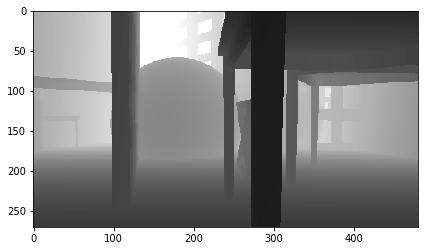

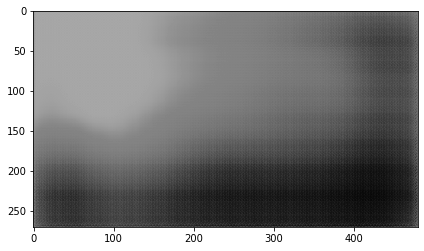

- Before encoding, mean: 0.442 var: 0.109
- After deconv 7, mean: -0.726 var: 1.924
- After sigmoid, mean: 0.388 var: 0.049
Epoch: 2/10, Step: 21/65, Avg loss: 7601.595, time: 88.53, Avg. per iter 4.35, Est. time left 191.31

- Before encoding, mean: 0.475 var: 0.114
- After deconv 7, mean: -0.723 var: 2.329
- After sigmoid, mean: 0.401 var: 0.054
Epoch: 2/10, Step: 22/65, Avg loss: 7575.673, time: 92.72, Avg. per iter 4.35, Est. time left 186.89

- Before encoding, mean: 0.408 var: 0.105
- After deconv 7, mean: -0.733 var: 1.898
- After sigmoid, mean: 0.385 var: 0.053
Epoch: 2/10, Step: 23/65, Avg loss: 7473.644, time: 96.88, Avg. per iter 4.34, Est. time left 182.45

- Before encoding, mean: 0.433 var: 0.106
- After deconv 7, mean: -0.697 var: 2.029
- After sigmoid, mean: 0.395 var: 0.053
Epoch: 2/10, Step: 24/65, Avg loss: 7399.217, time: 101.05, Avg. per iter 4.34, Est. time left 178.03

- Before encoding, mean: 0.425 var: 0.120
- After deconv 7, mean: -0.680 var: 1.760
- After sig

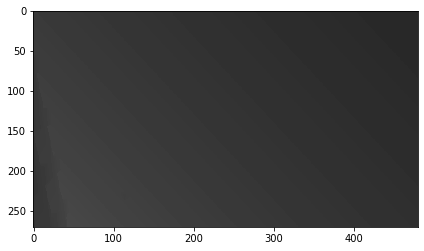

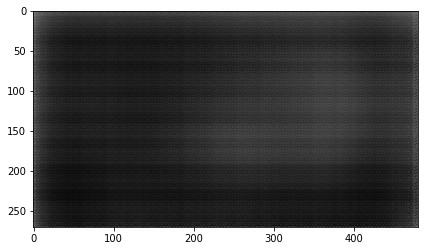

- Before encoding, mean: 0.402 var: 0.114
- After deconv 7, mean: -0.831 var: 2.155
- After sigmoid, mean: 0.368 var: 0.063
Epoch: 2/10, Step: 31/65, Avg loss: 7076.275, time: 131.09, Avg. per iter 4.34, Est. time left 147.41

- Before encoding, mean: 0.515 var: 0.115
- After deconv 7, mean: -0.839 var: 2.982
- After sigmoid, mean: 0.389 var: 0.072
Epoch: 2/10, Step: 32/65, Avg loss: 7084.513, time: 135.40, Avg. per iter 4.34, Est. time left 143.06

- Before encoding, mean: 0.465 var: 0.111
- After deconv 7, mean: -0.511 var: 1.944
- After sigmoid, mean: 0.422 var: 0.065
Epoch: 2/10, Step: 33/65, Avg loss: 7022.727, time: 139.72, Avg. per iter 4.34, Est. time left 138.72

- Before encoding, mean: 0.447 var: 0.115
- After deconv 7, mean: -0.204 var: 1.134
- After sigmoid, mean: 0.463 var: 0.051
Epoch: 2/10, Step: 34/65, Avg loss: 6999.645, time: 143.85, Avg. per iter 4.33, Est. time left 134.32

- Before encoding, mean: 0.428 var: 0.095
- After deconv 7, mean: -0.124 var: 1.097
- After 

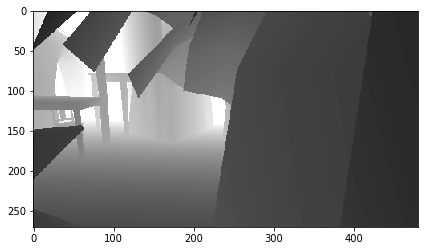

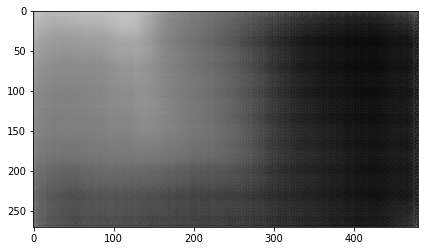

- Before encoding, mean: 0.492 var: 0.122
- After deconv 7, mean: -0.275 var: 1.904
- After sigmoid, mean: 0.457 var: 0.071
Epoch: 2/10, Step: 41/65, Avg loss: 6689.104, time: 173.56, Avg. per iter 4.33, Est. time left 103.80

- Before encoding, mean: 0.445 var: 0.124
- After deconv 7, mean: -0.136 var: 1.535
- After sigmoid, mean: 0.473 var: 0.066
Epoch: 2/10, Step: 42/65, Avg loss: 6636.198, time: 177.73, Avg. per iter 4.32, Est. time left 99.44

- Before encoding, mean: 0.430 var: 0.097
- After deconv 7, mean: -0.113 var: 1.576
- After sigmoid, mean: 0.481 var: 0.064
Epoch: 2/10, Step: 43/65, Avg loss: 6599.549, time: 181.88, Avg. per iter 4.32, Est. time left 95.09

- Before encoding, mean: 0.446 var: 0.102
- After deconv 7, mean: -0.303 var: 1.802
- After sigmoid, mean: 0.445 var: 0.070
Epoch: 2/10, Step: 44/65, Avg loss: 6550.639, time: 186.10, Avg. per iter 4.32, Est. time left 90.74

- Before encoding, mean: 0.422 var: 0.117
- After deconv 7, mean: -0.548 var: 2.051
- After sig

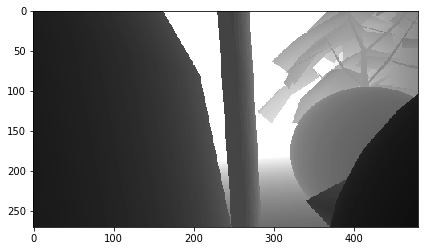

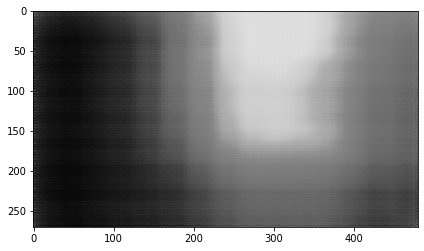

- Before encoding, mean: 0.441 var: 0.108
- After deconv 7, mean: -0.368 var: 1.785
- After sigmoid, mean: 0.425 var: 0.067
Epoch: 2/10, Step: 51/65, Avg loss: 6265.495, time: 215.69, Avg. per iter 4.31, Est. time left 60.39

- Before encoding, mean: 0.455 var: 0.127
- After deconv 7, mean: -0.330 var: 1.950
- After sigmoid, mean: 0.435 var: 0.073
Epoch: 2/10, Step: 52/65, Avg loss: 6235.140, time: 219.96, Avg. per iter 4.31, Est. time left 56.07

- Before encoding, mean: 0.464 var: 0.113
- After deconv 7, mean: -0.261 var: 1.775
- After sigmoid, mean: 0.442 var: 0.069
Epoch: 2/10, Step: 53/65, Avg loss: 6191.732, time: 224.18, Avg. per iter 4.31, Est. time left 51.75

- Before encoding, mean: 0.396 var: 0.093
- After deconv 7, mean: -0.103 var: 1.439
- After sigmoid, mean: 0.471 var: 0.059
Epoch: 2/10, Step: 54/65, Avg loss: 6153.422, time: 228.40, Avg. per iter 4.31, Est. time left 47.43

- Before encoding, mean: 0.420 var: 0.114
- After deconv 7, mean: -0.613 var: 2.654
- After sigm

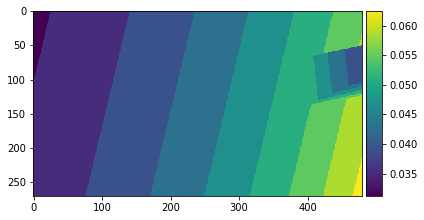

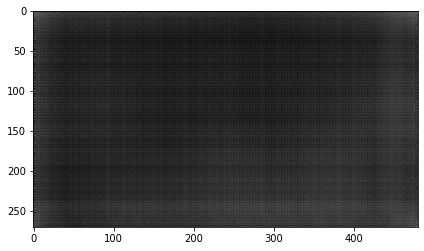

- Before encoding, mean: 0.429 var: 0.115
- After deconv 7, mean: -0.155 var: 1.736
- After sigmoid, mean: 0.461 var: 0.067
Epoch: 2/10, Step: 61/65, Avg loss: 5931.409, time: 258.29, Avg. per iter 4.31, Est. time left 17.23

- Before encoding, mean: 0.395 var: 0.103
- After deconv 7, mean: -0.556 var: 2.034
- After sigmoid, mean: 0.395 var: 0.066
Epoch: 2/10, Step: 62/65, Avg loss: 5895.117, time: 262.43, Avg. per iter 4.31, Est. time left 12.92

- Before encoding, mean: 0.465 var: 0.118
- After deconv 7, mean: -0.971 var: 3.822
- After sigmoid, mean: 0.356 var: 0.093
Epoch: 2/10, Step: 63/65, Avg loss: 5887.963, time: 266.54, Avg. per iter 4.30, Est. time left 8.61

- Before encoding, mean: 0.472 var: 0.116
- After deconv 7, mean: -0.883 var: 3.800
- After sigmoid, mean: 0.370 var: 0.091
Epoch: 2/10, Step: 64/65, Avg loss: 5877.669, time: 270.81, Avg. per iter 4.30, Est. time left 4.30

- Before encoding, mean: 0.497 var: 0.125
- After deconv 7, mean: -0.326 var: 2.901
- After sigmoi

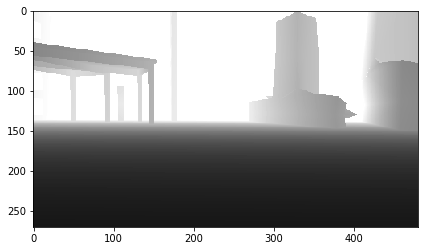

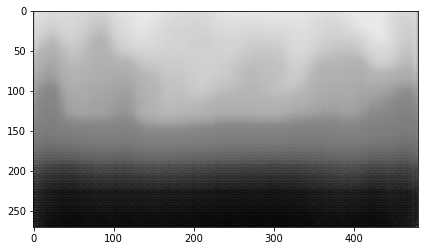

- Before encoding, mean: 0.460 var: 0.116
- After deconv 7, mean: -0.044 var: 1.800
- After sigmoid, mean: 0.479 var: 0.067
Epoch: 3/10, Step: 11/65, Avg loss: 4584.786, time: 46.22, Avg. per iter 4.28, Est. time left 231.17

- Before encoding, mean: 0.461 var: 0.109
- After deconv 7, mean: -0.080 var: 1.646
- After sigmoid, mean: 0.475 var: 0.061
Epoch: 3/10, Step: 12/65, Avg loss: 4520.943, time: 50.34, Avg. per iter 4.28, Est. time left 226.83

- Before encoding, mean: 0.464 var: 0.112
- After deconv 7, mean: -0.076 var: 1.819
- After sigmoid, mean: 0.474 var: 0.066
Epoch: 3/10, Step: 13/65, Avg loss: 4553.227, time: 54.43, Avg. per iter 4.28, Est. time left 222.49

- Before encoding, mean: 0.434 var: 0.121
- After deconv 7, mean: -0.192 var: 2.404
- After sigmoid, mean: 0.455 var: 0.082
Epoch: 3/10, Step: 14/65, Avg loss: 4518.517, time: 58.55, Avg. per iter 4.28, Est. time left 218.15

- Before encoding, mean: 0.427 var: 0.132
- After deconv 7, mean: -0.415 var: 3.264
- After sigm

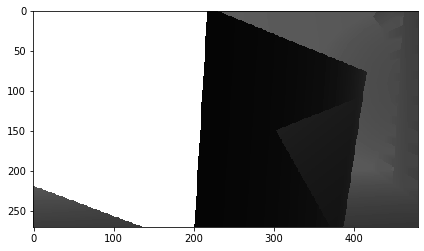

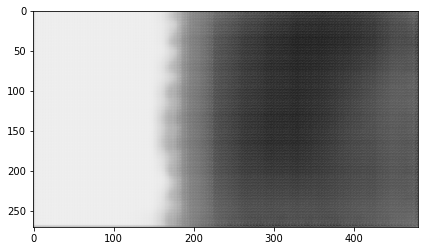

- Before encoding, mean: 0.441 var: 0.112
- After deconv 7, mean: -0.072 var: 1.902
- After sigmoid, mean: 0.473 var: 0.067
Epoch: 3/10, Step: 21/65, Avg loss: 4327.949, time: 88.66, Avg. per iter 4.28, Est. time left 188.20

- Before encoding, mean: 0.503 var: 0.129
- After deconv 7, mean: -0.167 var: 2.298
- After sigmoid, mean: 0.465 var: 0.076
Epoch: 3/10, Step: 22/65, Avg loss: 4353.518, time: 93.01, Avg. per iter 4.28, Est. time left 183.94

- Before encoding, mean: 0.426 var: 0.111
- After deconv 7, mean: -0.429 var: 2.709
- After sigmoid, mean: 0.417 var: 0.084
Epoch: 3/10, Step: 23/65, Avg loss: 4319.027, time: 97.33, Avg. per iter 4.28, Est. time left 179.68

- Before encoding, mean: 0.404 var: 0.115
- After deconv 7, mean: -0.578 var: 2.943
- After sigmoid, mean: 0.396 var: 0.085
Epoch: 3/10, Step: 24/65, Avg loss: 4339.642, time: 101.88, Avg. per iter 4.28, Est. time left 175.47

- Before encoding, mean: 0.453 var: 0.094
- After deconv 7, mean: -0.648 var: 3.378
- After sig

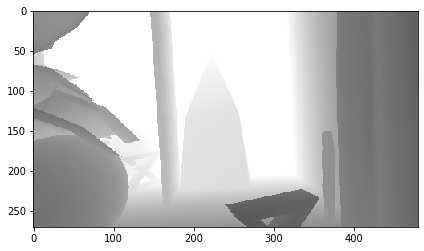

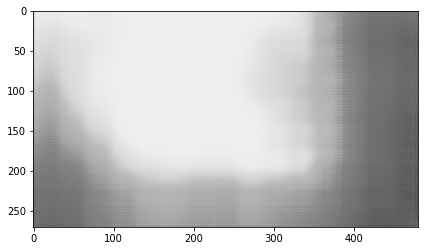

- Before encoding, mean: 0.412 var: 0.108
- After deconv 7, mean: -0.616 var: 2.786
- After sigmoid, mean: 0.390 var: 0.080
Epoch: 3/10, Step: 31/65, Avg loss: 4192.390, time: 132.71, Avg. per iter 4.28, Est. time left 145.65

- Before encoding, mean: 0.416 var: 0.103
- After deconv 7, mean: -0.673 var: 2.798
- After sigmoid, mean: 0.383 var: 0.079
Epoch: 3/10, Step: 32/65, Avg loss: 4185.718, time: 136.89, Avg. per iter 4.28, Est. time left 141.35

- Before encoding, mean: 0.515 var: 0.111
- After deconv 7, mean: -0.419 var: 2.988
- After sigmoid, mean: 0.432 var: 0.085
Epoch: 3/10, Step: 33/65, Avg loss: 4209.474, time: 141.11, Avg. per iter 4.28, Est. time left 137.05

- Before encoding, mean: 0.435 var: 0.111
- After deconv 7, mean: -0.118 var: 2.318
- After sigmoid, mean: 0.465 var: 0.078
Epoch: 3/10, Step: 34/65, Avg loss: 4210.323, time: 145.38, Avg. per iter 4.28, Est. time left 132.77

- Before encoding, mean: 0.490 var: 0.127
- After deconv 7, mean: 0.201 var: 2.470
- After s

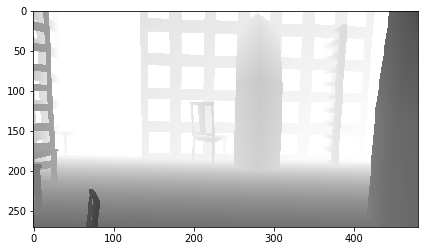

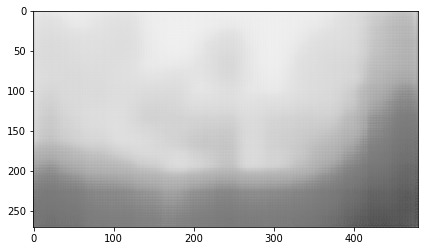

- Before encoding, mean: 0.513 var: 0.131
- After deconv 7, mean: -0.175 var: 2.729
- After sigmoid, mean: 0.469 var: 0.089
Epoch: 3/10, Step: 41/65, Avg loss: 4170.009, time: 176.51, Avg. per iter 4.29, Est. time left 102.92

- Before encoding, mean: 0.423 var: 0.112
- After deconv 7, mean: -0.154 var: 1.982
- After sigmoid, mean: 0.459 var: 0.071
Epoch: 3/10, Step: 42/65, Avg loss: 4163.404, time: 181.26, Avg. per iter 4.29, Est. time left 98.69

- Before encoding, mean: 0.479 var: 0.136
- After deconv 7, mean: 0.043 var: 2.549
- After sigmoid, mean: 0.481 var: 0.084
Epoch: 3/10, Step: 43/65, Avg loss: 4158.671, time: 185.69, Avg. per iter 4.29, Est. time left 94.42

- Before encoding, mean: 0.508 var: 0.113
- After deconv 7, mean: 0.046 var: 2.837
- After sigmoid, mean: 0.491 var: 0.089
Epoch: 3/10, Step: 44/65, Avg loss: 4136.091, time: 190.01, Avg. per iter 4.29, Est. time left 90.13

- Before encoding, mean: 0.402 var: 0.082
- After deconv 7, mean: -0.150 var: 2.216
- After sigmo

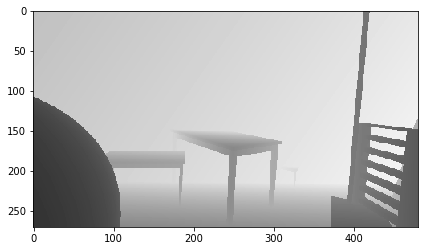

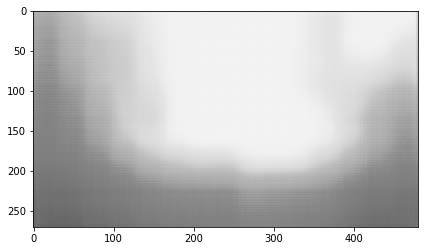

- Before encoding, mean: 0.447 var: 0.111
- After deconv 7, mean: 0.296 var: 1.842
- After sigmoid, mean: 0.529 var: 0.058
Epoch: 3/10, Step: 51/65, Avg loss: 4088.891, time: 220.80, Avg. per iter 4.29, Est. time left 60.13

- Before encoding, mean: 0.438 var: 0.110
- After deconv 7, mean: 0.253 var: 1.843
- After sigmoid, mean: 0.526 var: 0.063
Epoch: 3/10, Step: 52/65, Avg loss: 4108.712, time: 225.82, Avg. per iter 4.30, Est. time left 55.89

- Before encoding, mean: 0.451 var: 0.090
- After deconv 7, mean: -0.098 var: 2.060
- After sigmoid, mean: 0.467 var: 0.069
Epoch: 3/10, Step: 53/65, Avg loss: 4104.191, time: 230.29, Avg. per iter 4.30, Est. time left 51.60

- Before encoding, mean: 0.399 var: 0.090
- After deconv 7, mean: -0.626 var: 3.278
- After sigmoid, mean: 0.392 var: 0.087
Epoch: 3/10, Step: 54/65, Avg loss: 4098.788, time: 234.69, Avg. per iter 4.30, Est. time left 47.30

- Before encoding, mean: 0.442 var: 0.108
- After deconv 7, mean: -0.930 var: 4.384
- After sigmoi

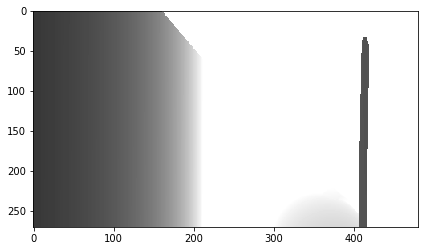

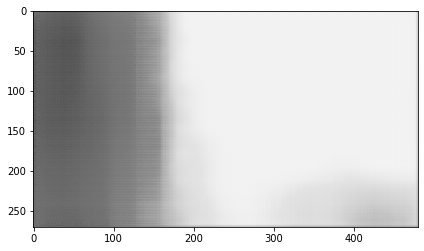

- Before encoding, mean: 0.455 var: 0.099
- After deconv 7, mean: 0.244 var: 1.799
- After sigmoid, mean: 0.527 var: 0.061
Epoch: 3/10, Step: 61/65, Avg loss: 4100.547, time: 264.94, Avg. per iter 4.30, Est. time left 17.20

- Before encoding, mean: 0.370 var: 0.097
- After deconv 7, mean: -0.005 var: 1.890
- After sigmoid, mean: 0.478 var: 0.066
Epoch: 3/10, Step: 62/65, Avg loss: 4109.683, time: 269.29, Avg. per iter 4.30, Est. time left 12.90

- Before encoding, mean: 0.406 var: 0.107
- After deconv 7, mean: -0.372 var: 2.675
- After sigmoid, mean: 0.417 var: 0.078
Epoch: 3/10, Step: 63/65, Avg loss: 4099.085, time: 273.57, Avg. per iter 4.30, Est. time left 8.60

- Before encoding, mean: 0.407 var: 0.096
- After deconv 7, mean: -1.166 var: 4.114
- After sigmoid, mean: 0.330 var: 0.084
Epoch: 3/10, Step: 64/65, Avg loss: 4092.188, time: 278.20, Avg. per iter 4.30, Est. time left 4.30

- Before encoding, mean: 0.420 var: 0.104
- After deconv 7, mean: -1.505 var: 5.705
- After sigmoid

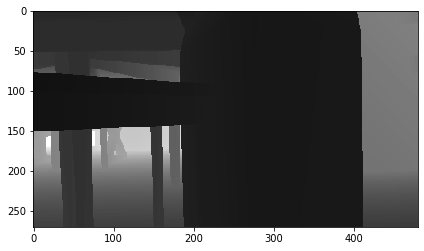

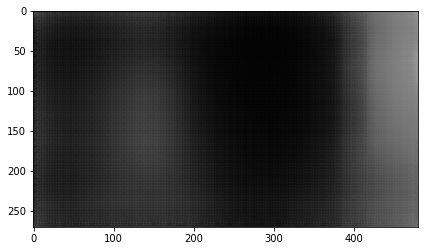

- Before encoding, mean: 0.459 var: 0.131
- After deconv 7, mean: -0.717 var: 3.588
- After sigmoid, mean: 0.393 var: 0.092
Epoch: 4/10, Step: 11/65, Avg loss: 4216.805, time: 47.24, Avg. per iter 4.29, Est. time left 231.82

- Before encoding, mean: 0.447 var: 0.095
- After deconv 7, mean: -0.396 var: 2.775
- After sigmoid, mean: 0.429 var: 0.079
Epoch: 4/10, Step: 12/65, Avg loss: 4153.182, time: 51.70, Avg. per iter 4.29, Est. time left 227.57

- Before encoding, mean: 0.469 var: 0.100
- After deconv 7, mean: -0.089 var: 2.150
- After sigmoid, mean: 0.469 var: 0.069
Epoch: 4/10, Step: 13/65, Avg loss: 4150.398, time: 56.02, Avg. per iter 4.29, Est. time left 223.28

- Before encoding, mean: 0.435 var: 0.092
- After deconv 7, mean: 0.118 var: 1.994
- After sigmoid, mean: 0.497 var: 0.064
Epoch: 4/10, Step: 14/65, Avg loss: 4154.980, time: 60.28, Avg. per iter 4.29, Est. time left 218.98

- Before encoding, mean: 0.439 var: 0.104
- After deconv 7, mean: 0.148 var: 1.924
- After sigmoi

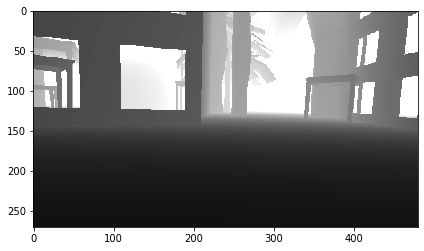

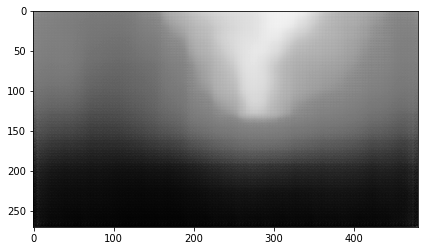

- Before encoding, mean: 0.363 var: 0.095
- After deconv 7, mean: -0.730 var: 3.269
- After sigmoid, mean: 0.369 var: 0.088
Epoch: 4/10, Step: 21/65, Avg loss: 3973.916, time: 90.60, Avg. per iter 4.29, Est. time left 188.94

- Before encoding, mean: 0.434 var: 0.108
- After deconv 7, mean: -0.528 var: 3.846
- After sigmoid, mean: 0.405 var: 0.096
Epoch: 4/10, Step: 22/65, Avg loss: 3940.355, time: 94.96, Avg. per iter 4.29, Est. time left 184.66

- Before encoding, mean: 0.436 var: 0.106
- After deconv 7, mean: -0.462 var: 3.256
- After sigmoid, mean: 0.407 var: 0.087
Epoch: 4/10, Step: 23/65, Avg loss: 3918.548, time: 99.38, Avg. per iter 4.29, Est. time left 180.39

- Before encoding, mean: 0.381 var: 0.092
- After deconv 7, mean: -0.414 var: 2.396
- After sigmoid, mean: 0.412 var: 0.074
Epoch: 4/10, Step: 24/65, Avg loss: 3888.733, time: 103.85, Avg. per iter 4.30, Est. time left 176.12

- Before encoding, mean: 0.469 var: 0.116
- After deconv 7, mean: -0.190 var: 2.949
- After sig

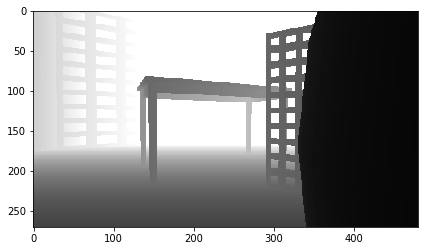

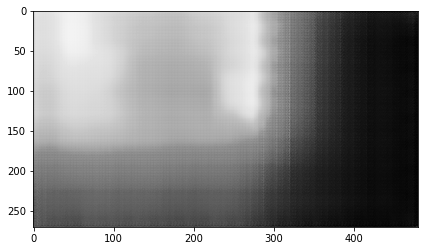

- Before encoding, mean: 0.416 var: 0.102
- After deconv 7, mean: -0.172 var: 2.487
- After sigmoid, mean: 0.453 var: 0.077
Epoch: 4/10, Step: 31/65, Avg loss: 3777.380, time: 136.85, Avg. per iter 4.31, Est. time left 146.45

- Before encoding, mean: 0.558 var: 0.105
- After deconv 7, mean: 0.014 var: 3.067
- After sigmoid, mean: 0.493 var: 0.089
Epoch: 4/10, Step: 32/65, Avg loss: 3790.000, time: 141.79, Avg. per iter 4.31, Est. time left 142.24

- Before encoding, mean: 0.462 var: 0.107
- After deconv 7, mean: -0.062 var: 2.729
- After sigmoid, mean: 0.469 var: 0.083
Epoch: 4/10, Step: 33/65, Avg loss: 3790.297, time: 145.94, Avg. per iter 4.31, Est. time left 137.91

- Before encoding, mean: 0.491 var: 0.133
- After deconv 7, mean: 0.139 var: 3.092
- After sigmoid, mean: 0.500 var: 0.095
Epoch: 4/10, Step: 34/65, Avg loss: 3765.179, time: 150.07, Avg. per iter 4.31, Est. time left 133.57

- Before encoding, mean: 0.463 var: 0.105
- After deconv 7, mean: -0.013 var: 2.688
- After si

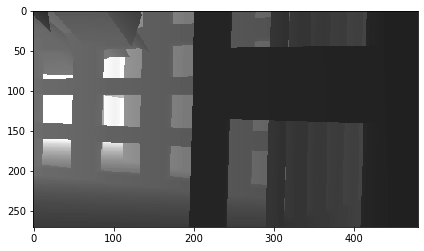

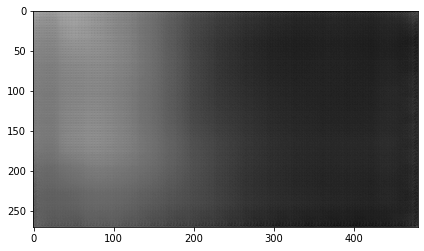

- Before encoding, mean: 0.449 var: 0.110
- After deconv 7, mean: -0.181 var: 2.941
- After sigmoid, mean: 0.448 var: 0.087
Epoch: 4/10, Step: 41/65, Avg loss: 3626.723, time: 180.90, Avg. per iter 4.31, Est. time left 103.46

- Before encoding, mean: 0.444 var: 0.102
- After deconv 7, mean: -0.200 var: 2.553
- After sigmoid, mean: 0.445 var: 0.078
Epoch: 4/10, Step: 42/65, Avg loss: 3606.998, time: 185.21, Avg. per iter 4.31, Est. time left 99.15

- Before encoding, mean: 0.410 var: 0.101
- After deconv 7, mean: -0.252 var: 2.248
- After sigmoid, mean: 0.435 var: 0.073
Epoch: 4/10, Step: 43/65, Avg loss: 3587.066, time: 189.48, Avg. per iter 4.31, Est. time left 94.83

- Before encoding, mean: 0.459 var: 0.095
- After deconv 7, mean: -0.253 var: 2.350
- After sigmoid, mean: 0.447 var: 0.071
Epoch: 4/10, Step: 44/65, Avg loss: 3582.611, time: 193.67, Avg. per iter 4.31, Est. time left 90.51

- Before encoding, mean: 0.415 var: 0.111
- After deconv 7, mean: -0.360 var: 2.493
- After sig

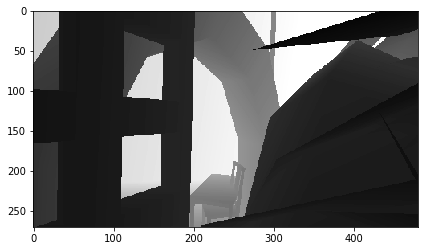

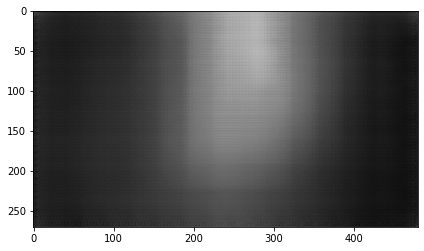

- Before encoding, mean: 0.500 var: 0.115
- After deconv 7, mean: -0.221 var: 3.900
- After sigmoid, mean: 0.452 var: 0.103
Epoch: 4/10, Step: 51/65, Avg loss: 3523.111, time: 223.65, Avg. per iter 4.31, Est. time left 60.32

- Before encoding, mean: 0.466 var: 0.123
- After deconv 7, mean: -0.101 var: 3.435
- After sigmoid, mean: 0.462 var: 0.097
Epoch: 4/10, Step: 52/65, Avg loss: 3509.510, time: 227.92, Avg. per iter 4.31, Est. time left 56.01

- Before encoding, mean: 0.552 var: 0.123
- After deconv 7, mean: 0.360 var: 3.539
- After sigmoid, mean: 0.531 var: 0.100
Epoch: 4/10, Step: 53/65, Avg loss: 3510.834, time: 232.15, Avg. per iter 4.31, Est. time left 51.70

- Before encoding, mean: 0.446 var: 0.104
- After deconv 7, mean: 0.071 var: 2.781
- After sigmoid, mean: 0.482 var: 0.083
Epoch: 4/10, Step: 54/65, Avg loss: 3500.969, time: 236.42, Avg. per iter 4.31, Est. time left 47.39

- Before encoding, mean: 0.415 var: 0.101
- After deconv 7, mean: -0.041 var: 2.419
- After sigmoi

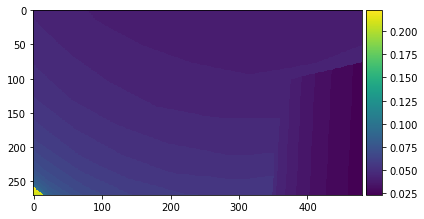

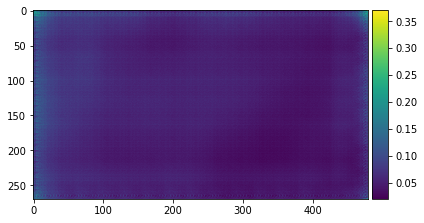

- Before encoding, mean: 0.492 var: 0.092
- After deconv 7, mean: -0.278 var: 3.314
- After sigmoid, mean: 0.446 var: 0.087
Epoch: 4/10, Step: 61/65, Avg loss: 3447.827, time: 266.35, Avg. per iter 4.31, Est. time left 17.22

- Before encoding, mean: 0.418 var: 0.097
- After deconv 7, mean: -0.106 var: 2.748
- After sigmoid, mean: 0.462 var: 0.080
Epoch: 4/10, Step: 62/65, Avg loss: 3452.318, time: 270.60, Avg. per iter 4.31, Est. time left 12.92

- Before encoding, mean: 0.421 var: 0.119
- After deconv 7, mean: 0.048 var: 2.803
- After sigmoid, mean: 0.481 var: 0.082
Epoch: 4/10, Step: 63/65, Avg loss: 3451.738, time: 274.93, Avg. per iter 4.31, Est. time left 8.61

- Before encoding, mean: 0.465 var: 0.115
- After deconv 7, mean: 0.043 var: 2.803
- After sigmoid, mean: 0.490 var: 0.085
Epoch: 4/10, Step: 64/65, Avg loss: 3443.266, time: 279.79, Avg. per iter 4.31, Est. time left 4.31

- Before encoding, mean: 0.413 var: 0.097
- After deconv 7, mean: -0.386 var: 2.429
- After sigmoid,

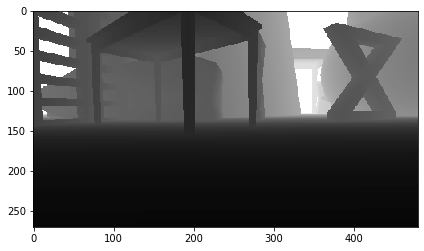

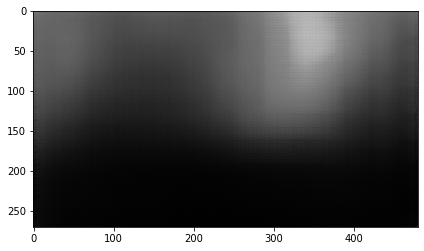

- Before encoding, mean: 0.456 var: 0.101
- After deconv 7, mean: -0.354 var: 3.207
- After sigmoid, mean: 0.432 var: 0.088
Epoch: 5/10, Step: 11/65, Avg loss: 3272.783, time: 50.53, Avg. per iter 4.31, Est. time left 232.84

- Before encoding, mean: 0.400 var: 0.096
- After deconv 7, mean: -0.139 var: 2.427
- After sigmoid, mean: 0.460 var: 0.073
Epoch: 5/10, Step: 12/65, Avg loss: 3303.943, time: 54.81, Avg. per iter 4.31, Est. time left 228.52

- Before encoding, mean: 0.466 var: 0.124
- After deconv 7, mean: 0.182 var: 2.976
- After sigmoid, mean: 0.505 var: 0.085
Epoch: 5/10, Step: 13/65, Avg loss: 3321.992, time: 59.67, Avg. per iter 4.31, Est. time left 224.32

- Before encoding, mean: 0.439 var: 0.111
- After deconv 7, mean: -0.035 var: 2.883
- After sigmoid, mean: 0.467 var: 0.084
Epoch: 5/10, Step: 14/65, Avg loss: 3257.823, time: 64.99, Avg. per iter 4.32, Est. time left 220.19

- Before encoding, mean: 0.471 var: 0.136
- After deconv 7, mean: 0.018 var: 3.669
- After sigmoi

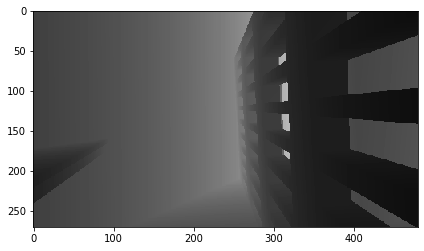

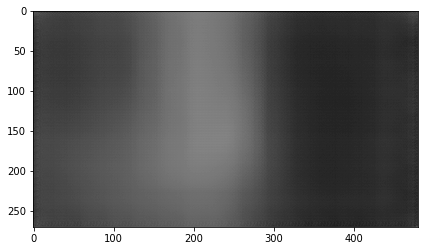

- Before encoding, mean: 0.500 var: 0.096
- After deconv 7, mean: -0.007 var: 3.162
- After sigmoid, mean: 0.478 var: 0.084
Epoch: 5/10, Step: 21/65, Avg loss: 3098.601, time: 96.23, Avg. per iter 4.32, Est. time left 190.10

- Before encoding, mean: 0.505 var: 0.109
- After deconv 7, mean: 0.213 var: 3.453
- After sigmoid, mean: 0.504 var: 0.089
Epoch: 5/10, Step: 22/65, Avg loss: 3082.041, time: 100.76, Avg. per iter 4.32, Est. time left 185.81

- Before encoding, mean: 0.436 var: 0.108
- After deconv 7, mean: 0.030 var: 2.920
- After sigmoid, mean: 0.473 var: 0.080
Epoch: 5/10, Step: 23/65, Avg loss: 3084.206, time: 105.20, Avg. per iter 4.32, Est. time left 181.50

- Before encoding, mean: 0.421 var: 0.097
- After deconv 7, mean: -0.058 var: 2.904
- After sigmoid, mean: 0.462 var: 0.079
Epoch: 5/10, Step: 24/65, Avg loss: 3081.413, time: 109.77, Avg. per iter 4.32, Est. time left 177.22

- Before encoding, mean: 0.443 var: 0.121
- After deconv 7, mean: -0.135 var: 3.778
- After sig

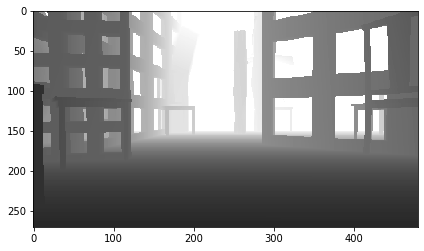

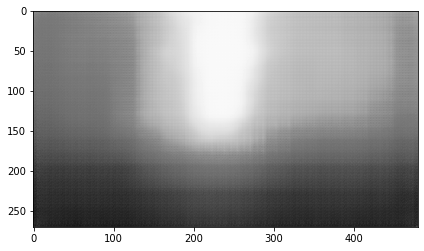

- Before encoding, mean: 0.358 var: 0.095
- After deconv 7, mean: -0.242 var: 2.190
- After sigmoid, mean: 0.429 var: 0.068
Epoch: 5/10, Step: 31/65, Avg loss: 2983.486, time: 141.63, Avg. per iter 4.33, Est. time left 147.12

- Before encoding, mean: 0.429 var: 0.132
- After deconv 7, mean: -0.227 var: 3.817
- After sigmoid, mean: 0.438 var: 0.102
Epoch: 5/10, Step: 32/65, Avg loss: 2964.548, time: 145.98, Avg. per iter 4.33, Est. time left 142.80

- Before encoding, mean: 0.332 var: 0.071
- After deconv 7, mean: -0.817 var: 2.738
- After sigmoid, mean: 0.352 var: 0.069
Epoch: 5/10, Step: 33/65, Avg loss: 2961.118, time: 150.16, Avg. per iter 4.33, Est. time left 138.46

- Before encoding, mean: 0.461 var: 0.111
- After deconv 7, mean: -0.892 var: 5.309
- After sigmoid, mean: 0.367 var: 0.104
Epoch: 5/10, Step: 34/65, Avg loss: 2988.280, time: 154.47, Avg. per iter 4.33, Est. time left 134.13

- Before encoding, mean: 0.451 var: 0.124
- After deconv 7, mean: -0.751 var: 5.271
- After 

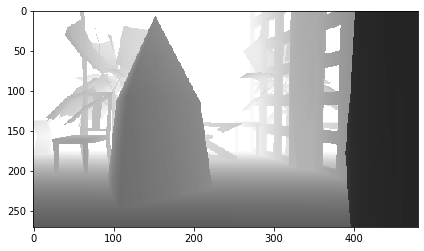

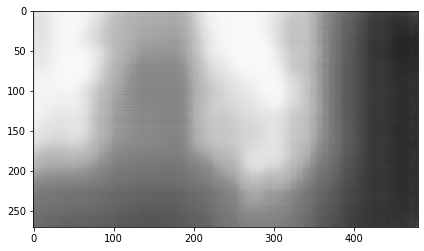

- Before encoding, mean: 0.446 var: 0.100
- After deconv 7, mean: -0.534 var: 2.965
- After sigmoid, mean: 0.403 var: 0.077
Epoch: 5/10, Step: 41/65, Avg loss: 3045.163, time: 184.58, Avg. per iter 4.33, Est. time left 103.81

- Before encoding, mean: 0.413 var: 0.089
- After deconv 7, mean: -0.800 var: 2.740
- After sigmoid, mean: 0.358 var: 0.070
Epoch: 5/10, Step: 42/65, Avg loss: 3044.101, time: 188.95, Avg. per iter 4.33, Est. time left 99.49

- Before encoding, mean: 0.434 var: 0.104
- After deconv 7, mean: -0.601 var: 3.436
- After sigmoid, mean: 0.384 var: 0.081
Epoch: 5/10, Step: 43/65, Avg loss: 3044.485, time: 193.48, Avg. per iter 4.33, Est. time left 95.18

- Before encoding, mean: 0.482 var: 0.115
- After deconv 7, mean: -0.277 var: 3.600
- After sigmoid, mean: 0.435 var: 0.093
Epoch: 5/10, Step: 44/65, Avg loss: 3032.544, time: 197.92, Avg. per iter 4.33, Est. time left 90.86

- Before encoding, mean: 0.403 var: 0.088
- After deconv 7, mean: -0.190 var: 2.538
- After sig

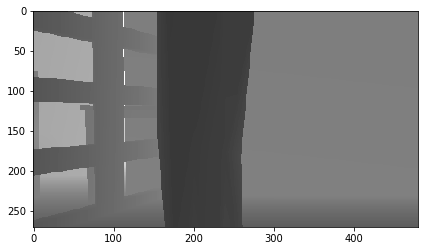

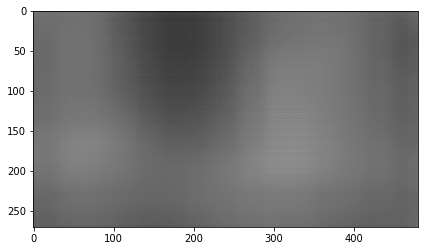

- Before encoding, mean: 0.440 var: 0.120
- After deconv 7, mean: -0.253 var: 3.396
- After sigmoid, mean: 0.429 var: 0.089
Epoch: 5/10, Step: 51/65, Avg loss: 3015.711, time: 228.26, Avg. per iter 4.33, Est. time left 60.57

- Before encoding, mean: 0.442 var: 0.134
- After deconv 7, mean: -0.146 var: 3.442
- After sigmoid, mean: 0.438 var: 0.094
Epoch: 5/10, Step: 52/65, Avg loss: 3021.096, time: 232.89, Avg. per iter 4.33, Est. time left 56.25

- Before encoding, mean: 0.486 var: 0.126
- After deconv 7, mean: -0.029 var: 3.542
- After sigmoid, mean: 0.468 var: 0.094
Epoch: 5/10, Step: 53/65, Avg loss: 3019.171, time: 237.75, Avg. per iter 4.33, Est. time left 51.95

- Before encoding, mean: 0.480 var: 0.099
- After deconv 7, mean: -0.044 var: 2.976
- After sigmoid, mean: 0.468 var: 0.079
Epoch: 5/10, Step: 54/65, Avg loss: 3021.872, time: 242.19, Avg. per iter 4.33, Est. time left 47.62

- Before encoding, mean: 0.522 var: 0.104
- After deconv 7, mean: 0.164 var: 3.295
- After sigmo

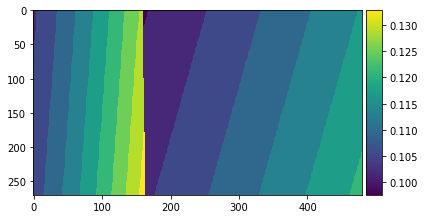

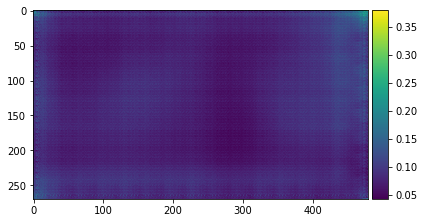

- Before encoding, mean: 0.471 var: 0.116
- After deconv 7, mean: -0.726 var: 4.320
- After sigmoid, mean: 0.376 var: 0.098
Epoch: 5/10, Step: 61/65, Avg loss: 3062.214, time: 273.07, Avg. per iter 4.33, Est. time left 17.32

- Before encoding, mean: 0.454 var: 0.104
- After deconv 7, mean: -0.631 var: 3.732
- After sigmoid, mean: 0.380 var: 0.091
Epoch: 5/10, Step: 62/65, Avg loss: 3062.292, time: 277.37, Avg. per iter 4.33, Est. time left 12.99

- Before encoding, mean: 0.477 var: 0.125
- After deconv 7, mean: -0.091 var: 3.646
- After sigmoid, mean: 0.450 var: 0.100
Epoch: 5/10, Step: 63/65, Avg loss: 3047.278, time: 281.64, Avg. per iter 4.33, Est. time left 8.66

- Before encoding, mean: 0.430 var: 0.104
- After deconv 7, mean: 0.039 var: 2.374
- After sigmoid, mean: 0.481 var: 0.070
Epoch: 5/10, Step: 64/65, Avg loss: 3052.589, time: 285.83, Avg. per iter 4.33, Est. time left 4.33

- Before encoding, mean: 0.454 var: 0.109
- After deconv 7, mean: 0.307 var: 2.641
- After sigmoid,

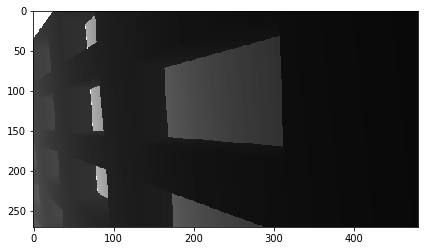

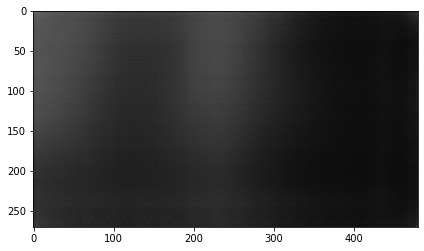

- Before encoding, mean: 0.483 var: 0.111
- After deconv 7, mean: 0.015 var: 3.030
- After sigmoid, mean: 0.481 var: 0.084
Epoch: 6/10, Step: 11/65, Avg loss: 2747.956, time: 48.62, Avg. per iter 4.33, Est. time left 233.61

- Before encoding, mean: 0.453 var: 0.120
- After deconv 7, mean: 0.025 var: 3.279
- After sigmoid, mean: 0.473 var: 0.088
Epoch: 6/10, Step: 12/65, Avg loss: 2756.790, time: 53.28, Avg. per iter 4.33, Est. time left 229.33

- Before encoding, mean: 0.535 var: 0.135
- After deconv 7, mean: 0.205 var: 4.363
- After sigmoid, mean: 0.500 var: 0.106
Epoch: 6/10, Step: 13/65, Avg loss: 2797.275, time: 57.80, Avg. per iter 4.33, Est. time left 225.03

- Before encoding, mean: 0.457 var: 0.101
- After deconv 7, mean: -0.085 var: 3.669
- After sigmoid, mean: 0.461 var: 0.090
Epoch: 6/10, Step: 14/65, Avg loss: 2782.313, time: 62.78, Avg. per iter 4.33, Est. time left 220.80

- Before encoding, mean: 0.396 var: 0.110
- After deconv 7, mean: -0.151 var: 3.914
- After sigmoid

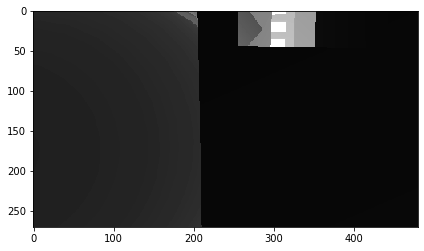

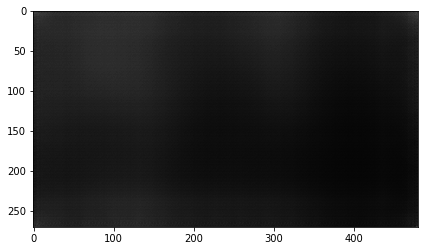

- Before encoding, mean: 0.446 var: 0.120
- After deconv 7, mean: -0.181 var: 3.533
- After sigmoid, mean: 0.440 var: 0.093
Epoch: 6/10, Step: 21/65, Avg loss: 2739.293, time: 94.51, Avg. per iter 4.33, Est. time left 190.64

- Before encoding, mean: 0.407 var: 0.124
- After deconv 7, mean: -0.162 var: 3.352
- After sigmoid, mean: 0.435 var: 0.089
Epoch: 6/10, Step: 22/65, Avg loss: 2745.193, time: 98.76, Avg. per iter 4.33, Est. time left 186.30

- Before encoding, mean: 0.511 var: 0.098
- After deconv 7, mean: -0.076 var: 3.435
- After sigmoid, mean: 0.462 var: 0.088
Epoch: 6/10, Step: 23/65, Avg loss: 2800.416, time: 103.10, Avg. per iter 4.33, Est. time left 181.97

- Before encoding, mean: 0.459 var: 0.115
- After deconv 7, mean: -0.019 var: 3.725
- After sigmoid, mean: 0.459 var: 0.094
Epoch: 6/10, Step: 24/65, Avg loss: 2800.101, time: 107.42, Avg. per iter 4.33, Est. time left 177.64

- Before encoding, mean: 0.409 var: 0.091
- After deconv 7, mean: -0.054 var: 2.868
- After si

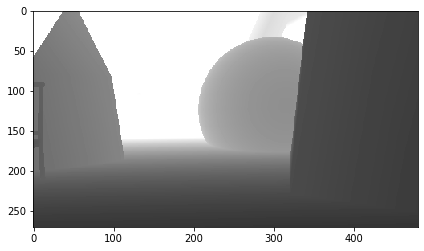

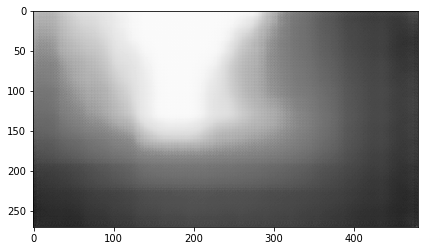

- Before encoding, mean: 0.417 var: 0.102
- After deconv 7, mean: -0.218 var: 3.030
- After sigmoid, mean: 0.430 var: 0.080
Epoch: 6/10, Step: 31/65, Avg loss: 2739.582, time: 137.86, Avg. per iter 4.33, Est. time left 147.30

- Before encoding, mean: 0.453 var: 0.112
- After deconv 7, mean: -0.054 var: 3.648
- After sigmoid, mean: 0.463 var: 0.095
Epoch: 6/10, Step: 32/65, Avg loss: 2723.780, time: 142.65, Avg. per iter 4.33, Est. time left 143.01

- Before encoding, mean: 0.418 var: 0.121
- After deconv 7, mean: -0.059 var: 3.667
- After sigmoid, mean: 0.452 var: 0.092
Epoch: 6/10, Step: 33/65, Avg loss: 2729.225, time: 147.45, Avg. per iter 4.33, Est. time left 138.72

- Before encoding, mean: 0.484 var: 0.118
- After deconv 7, mean: -0.005 var: 4.118
- After sigmoid, mean: 0.465 var: 0.101
Epoch: 6/10, Step: 34/65, Avg loss: 2755.879, time: 151.77, Avg. per iter 4.33, Est. time left 134.38

- Before encoding, mean: 0.366 var: 0.096
- After deconv 7, mean: -0.455 var: 3.119
- After 

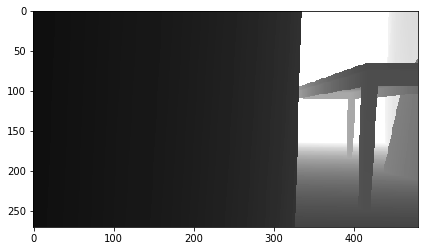

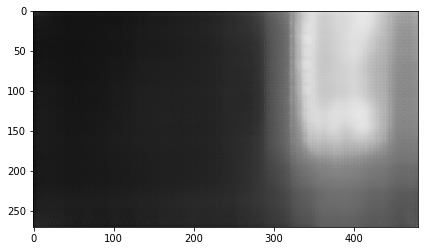

- Before encoding, mean: 0.479 var: 0.105
- After deconv 7, mean: 0.253 var: 3.783
- After sigmoid, mean: 0.506 var: 0.091
Epoch: 6/10, Step: 41/65, Avg loss: 2727.862, time: 183.48, Avg. per iter 4.34, Est. time left 104.11

- Before encoding, mean: 0.433 var: 0.102
- After deconv 7, mean: 0.058 var: 3.010
- After sigmoid, mean: 0.480 var: 0.079
Epoch: 6/10, Step: 42/65, Avg loss: 2747.987, time: 188.85, Avg. per iter 4.34, Est. time left 99.84

- Before encoding, mean: 0.468 var: 0.086
- After deconv 7, mean: -0.131 var: 2.844
- After sigmoid, mean: 0.451 var: 0.072
Epoch: 6/10, Step: 43/65, Avg loss: 2759.759, time: 193.55, Avg. per iter 4.34, Est. time left 95.52

- Before encoding, mean: 0.457 var: 0.101
- After deconv 7, mean: -0.143 var: 3.360
- After sigmoid, mean: 0.441 var: 0.081
Epoch: 6/10, Step: 44/65, Avg loss: 2765.654, time: 198.02, Avg. per iter 4.34, Est. time left 91.19

- Before encoding, mean: 0.441 var: 0.114
- After deconv 7, mean: -0.260 var: 3.481
- After sigmo

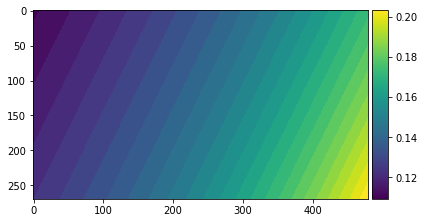

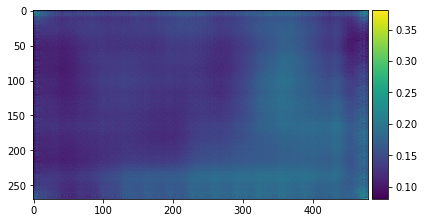

- Before encoding, mean: 0.501 var: 0.105
- After deconv 7, mean: -0.129 var: 4.088
- After sigmoid, mean: 0.454 var: 0.098
Epoch: 6/10, Step: 51/65, Avg loss: 2744.673, time: 229.88, Avg. per iter 4.35, Est. time left 60.83

- Before encoding, mean: 0.501 var: 0.117
- After deconv 7, mean: 0.034 var: 4.608
- After sigmoid, mean: 0.476 var: 0.107
Epoch: 6/10, Step: 52/65, Avg loss: 2737.802, time: 234.22, Avg. per iter 4.35, Est. time left 56.49

- Before encoding, mean: 0.464 var: 0.124
- After deconv 7, mean: 0.097 var: 4.165
- After sigmoid, mean: 0.485 var: 0.104
Epoch: 6/10, Step: 53/65, Avg loss: 2733.997, time: 238.96, Avg. per iter 4.35, Est. time left 52.16

- Before encoding, mean: 0.395 var: 0.114
- After deconv 7, mean: -0.074 var: 3.289
- After sigmoid, mean: 0.452 var: 0.086
Epoch: 6/10, Step: 54/65, Avg loss: 2739.349, time: 243.40, Avg. per iter 4.35, Est. time left 47.81

- Before encoding, mean: 0.451 var: 0.095
- After deconv 7, mean: -0.184 var: 3.422
- After sigmoi

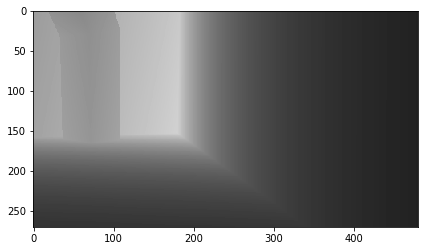

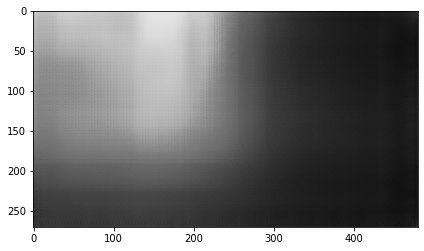

- Before encoding, mean: 0.436 var: 0.135
- After deconv 7, mean: 0.080 var: 4.468
- After sigmoid, mean: 0.467 var: 0.106
Epoch: 6/10, Step: 61/65, Avg loss: 2744.943, time: 274.54, Avg. per iter 4.35, Est. time left 17.39

- Before encoding, mean: 0.406 var: 0.091
- After deconv 7, mean: -0.160 var: 3.642
- After sigmoid, mean: 0.436 var: 0.086
Epoch: 6/10, Step: 62/65, Avg loss: 2734.246, time: 279.02, Avg. per iter 4.35, Est. time left 13.04

- Before encoding, mean: 0.495 var: 0.101
- After deconv 7, mean: 0.016 var: 4.084
- After sigmoid, mean: 0.466 var: 0.093
Epoch: 6/10, Step: 63/65, Avg loss: 2737.764, time: 283.35, Avg. per iter 4.35, Est. time left 8.70

- Before encoding, mean: 0.421 var: 0.098
- After deconv 7, mean: -0.173 var: 3.241
- After sigmoid, mean: 0.433 var: 0.083
Epoch: 6/10, Step: 64/65, Avg loss: 2733.774, time: 287.84, Avg. per iter 4.35, Est. time left 4.35

- Before encoding, mean: 0.495 var: 0.101
- After deconv 7, mean: 0.059 var: 3.335
- After sigmoid, 

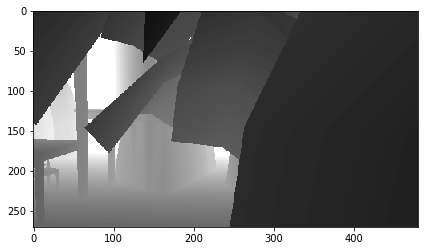

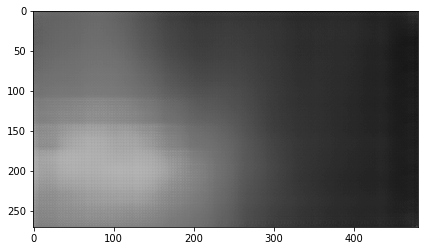

- Before encoding, mean: 0.503 var: 0.125
- After deconv 7, mean: 0.001 var: 4.389
- After sigmoid, mean: 0.473 var: 0.101
Epoch: 7/10, Step: 11/65, Avg loss: 2637.114, time: 48.30, Avg. per iter 4.34, Est. time left 234.60

- Before encoding, mean: 0.438 var: 0.118
- After deconv 7, mean: -0.213 var: 4.497
- After sigmoid, mean: 0.420 var: 0.102
Epoch: 7/10, Step: 12/65, Avg loss: 2579.433, time: 52.40, Avg. per iter 4.34, Est. time left 230.22

- Before encoding, mean: 0.480 var: 0.109
- After deconv 7, mean: -0.093 var: 3.864
- After sigmoid, mean: 0.465 var: 0.093
Epoch: 7/10, Step: 13/65, Avg loss: 2641.357, time: 56.61, Avg. per iter 4.34, Est. time left 225.86

- Before encoding, mean: 0.497 var: 0.120
- After deconv 7, mean: 0.152 var: 4.494
- After sigmoid, mean: 0.491 var: 0.103
Epoch: 7/10, Step: 14/65, Avg loss: 2634.964, time: 61.34, Avg. per iter 4.34, Est. time left 221.56

- Before encoding, mean: 0.458 var: 0.096
- After deconv 7, mean: 0.004 var: 3.451
- After sigmoid

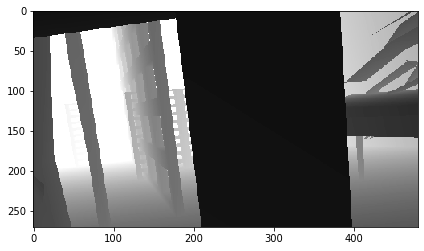

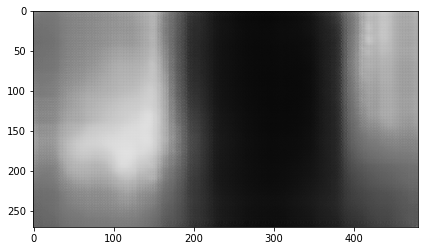

- Before encoding, mean: 0.477 var: 0.119
- After deconv 7, mean: -0.191 var: 4.804
- After sigmoid, mean: 0.447 var: 0.110
Epoch: 7/10, Step: 21/65, Avg loss: 2552.063, time: 92.80, Avg. per iter 4.35, Est. time left 191.24

- Before encoding, mean: 0.422 var: 0.093
- After deconv 7, mean: -0.307 var: 3.458
- After sigmoid, mean: 0.425 var: 0.088
Epoch: 7/10, Step: 22/65, Avg loss: 2536.532, time: 97.04, Avg. per iter 4.35, Est. time left 186.88

- Before encoding, mean: 0.523 var: 0.120
- After deconv 7, mean: 0.511 var: 5.093
- After sigmoid, mean: 0.528 var: 0.109
Epoch: 7/10, Step: 23/65, Avg loss: 2508.174, time: 101.19, Avg. per iter 4.35, Est. time left 182.52

- Before encoding, mean: 0.422 var: 0.103
- After deconv 7, mean: 0.012 var: 3.074
- After sigmoid, mean: 0.464 var: 0.078
Epoch: 7/10, Step: 24/65, Avg loss: 2511.446, time: 105.45, Avg. per iter 4.35, Est. time left 178.16

- Before encoding, mean: 0.463 var: 0.095
- After deconv 7, mean: -0.022 var: 2.757
- After sigm

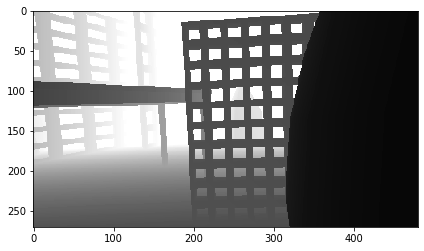

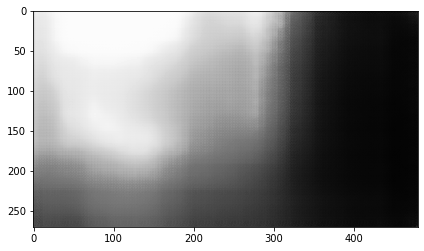

- Before encoding, mean: 0.492 var: 0.123
- After deconv 7, mean: 0.038 var: 6.900
- After sigmoid, mean: 0.454 var: 0.130
Epoch: 7/10, Step: 31/65, Avg loss: 2491.300, time: 136.32, Avg. per iter 4.35, Est. time left 147.77

- Before encoding, mean: 0.453 var: 0.116
- After deconv 7, mean: -0.135 var: 5.122
- After sigmoid, mean: 0.446 var: 0.107
Epoch: 7/10, Step: 32/65, Avg loss: 2500.180, time: 141.08, Avg. per iter 4.35, Est. time left 143.45

- Before encoding, mean: 0.452 var: 0.119
- After deconv 7, mean: 0.003 var: 4.682
- After sigmoid, mean: 0.459 var: 0.105
Epoch: 7/10, Step: 33/65, Avg loss: 2492.931, time: 145.56, Avg. per iter 4.35, Est. time left 139.12

- Before encoding, mean: 0.465 var: 0.107
- After deconv 7, mean: -0.034 var: 3.487
- After sigmoid, mean: 0.465 var: 0.087
Epoch: 7/10, Step: 34/65, Avg loss: 2496.468, time: 150.18, Avg. per iter 4.35, Est. time left 134.79

- Before encoding, mean: 0.416 var: 0.108
- After deconv 7, mean: -0.128 var: 2.762
- After si

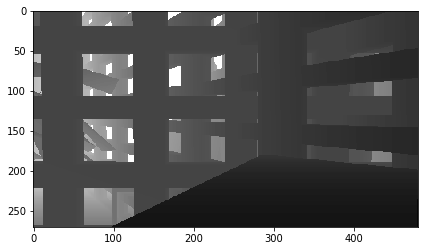

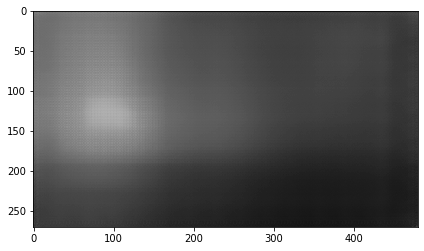

- Before encoding, mean: 0.434 var: 0.113
- After deconv 7, mean: 0.164 var: 4.367
- After sigmoid, mean: 0.479 var: 0.095
Epoch: 7/10, Step: 41/65, Avg loss: 2516.333, time: 181.20, Avg. per iter 4.35, Est. time left 104.37

- Before encoding, mean: 0.413 var: 0.089
- After deconv 7, mean: -0.199 var: 3.344
- After sigmoid, mean: 0.432 var: 0.082
Epoch: 7/10, Step: 42/65, Avg loss: 2516.009, time: 185.39, Avg. per iter 4.35, Est. time left 100.02

- Before encoding, mean: 0.379 var: 0.101
- After deconv 7, mean: -0.492 var: 3.495
- After sigmoid, mean: 0.378 var: 0.084
Epoch: 7/10, Step: 43/65, Avg loss: 2516.427, time: 189.58, Avg. per iter 4.35, Est. time left 95.66

- Before encoding, mean: 0.355 var: 0.092
- After deconv 7, mean: -0.829 var: 2.896
- After sigmoid, mean: 0.329 var: 0.072
Epoch: 7/10, Step: 44/65, Avg loss: 2509.135, time: 193.84, Avg. per iter 4.35, Est. time left 91.31

- Before encoding, mean: 0.331 var: 0.117
- After deconv 7, mean: -0.709 var: 4.077
- After sig

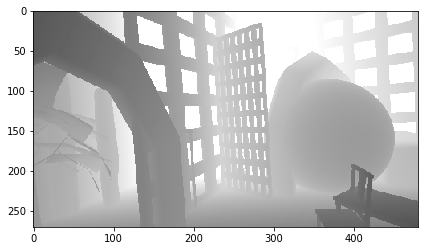

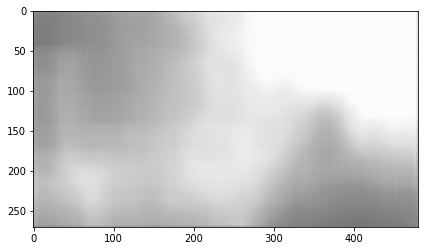

- Before encoding, mean: 0.447 var: 0.102
- After deconv 7, mean: -0.072 var: 3.754
- After sigmoid, mean: 0.451 var: 0.090
Epoch: 7/10, Step: 51/65, Avg loss: 2527.826, time: 223.53, Avg. per iter 4.35, Est. time left 60.84

- Before encoding, mean: 0.377 var: 0.102
- After deconv 7, mean: -0.417 var: 3.404
- After sigmoid, mean: 0.397 var: 0.084
Epoch: 7/10, Step: 52/65, Avg loss: 2522.100, time: 227.85, Avg. per iter 4.35, Est. time left 56.49

- Before encoding, mean: 0.464 var: 0.097
- After deconv 7, mean: -0.397 var: 3.315
- After sigmoid, mean: 0.412 var: 0.083
Epoch: 7/10, Step: 53/65, Avg loss: 2530.762, time: 232.23, Avg. per iter 4.35, Est. time left 52.15

- Before encoding, mean: 0.402 var: 0.109
- After deconv 7, mean: -0.494 var: 3.206
- After sigmoid, mean: 0.396 var: 0.082
Epoch: 7/10, Step: 54/65, Avg loss: 2531.515, time: 236.69, Avg. per iter 4.35, Est. time left 47.81

- Before encoding, mean: 0.480 var: 0.097
- After deconv 7, mean: -0.272 var: 2.931
- After sigm

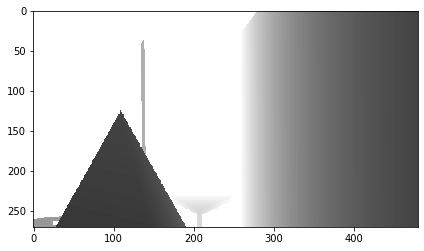

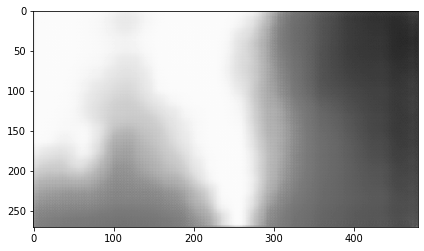

- Before encoding, mean: 0.418 var: 0.097
- After deconv 7, mean: -0.391 var: 3.882
- After sigmoid, mean: 0.417 var: 0.090
Epoch: 7/10, Step: 61/65, Avg loss: 2520.577, time: 267.78, Avg. per iter 4.35, Est. time left 17.39

- Before encoding, mean: 0.466 var: 0.118
- After deconv 7, mean: -0.190 var: 4.631
- After sigmoid, mean: 0.435 var: 0.105
Epoch: 7/10, Step: 62/65, Avg loss: 2522.905, time: 272.42, Avg. per iter 4.35, Est. time left 13.04

- Before encoding, mean: 0.476 var: 0.109
- After deconv 7, mean: -0.103 var: 4.017
- After sigmoid, mean: 0.446 var: 0.094
Epoch: 7/10, Step: 63/65, Avg loss: 2522.092, time: 276.79, Avg. per iter 4.35, Est. time left 8.70

- Before encoding, mean: 0.501 var: 0.138
- After deconv 7, mean: 0.441 var: 4.810
- After sigmoid, mean: 0.517 var: 0.106
Epoch: 7/10, Step: 64/65, Avg loss: 2520.750, time: 281.15, Avg. per iter 4.35, Est. time left 4.35

- Before encoding, mean: 0.394 var: 0.088
- After deconv 7, mean: -0.071 var: 2.916
- After sigmoid

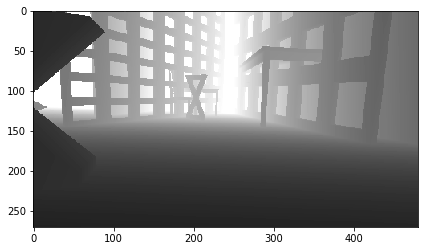

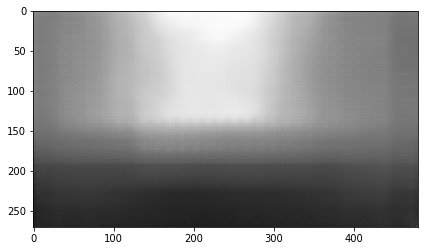

- Before encoding, mean: 0.446 var: 0.105
- After deconv 7, mean: -0.158 var: 3.812
- After sigmoid, mean: 0.443 var: 0.094
Epoch: 8/10, Step: 11/65, Avg loss: 2387.929, time: 49.79, Avg. per iter 4.35, Est. time left 234.76

- Before encoding, mean: 0.407 var: 0.102
- After deconv 7, mean: -0.463 var: 3.660
- After sigmoid, mean: 0.398 var: 0.090
Epoch: 8/10, Step: 12/65, Avg loss: 2358.965, time: 54.09, Avg. per iter 4.35, Est. time left 230.41

- Before encoding, mean: 0.458 var: 0.110
- After deconv 7, mean: -0.387 var: 4.475
- After sigmoid, mean: 0.413 var: 0.102
Epoch: 8/10, Step: 13/65, Avg loss: 2368.410, time: 58.69, Avg. per iter 4.35, Est. time left 226.09

- Before encoding, mean: 0.452 var: 0.112
- After deconv 7, mean: -0.242 var: 4.295
- After sigmoid, mean: 0.426 var: 0.097
Epoch: 8/10, Step: 14/65, Avg loss: 2352.873, time: 63.24, Avg. per iter 4.35, Est. time left 221.76

- Before encoding, mean: 0.384 var: 0.119
- After deconv 7, mean: -0.187 var: 3.892
- After sigm

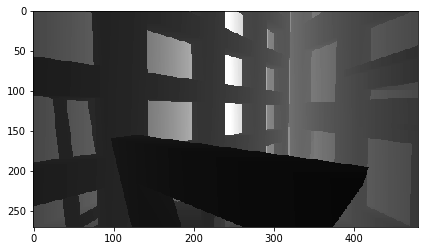

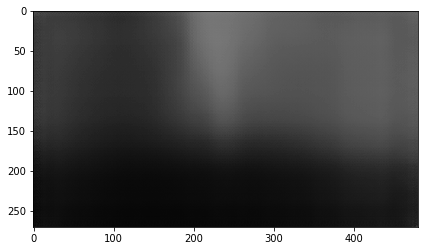

- Before encoding, mean: 0.453 var: 0.109
- After deconv 7, mean: 0.061 var: 3.717
- After sigmoid, mean: 0.469 var: 0.086
Epoch: 8/10, Step: 21/65, Avg loss: 2326.959, time: 96.57, Avg. per iter 4.35, Est. time left 191.56

- Before encoding, mean: 0.465 var: 0.117
- After deconv 7, mean: 0.249 var: 3.643
- After sigmoid, mean: 0.503 var: 0.088
Epoch: 8/10, Step: 22/65, Avg loss: 2353.035, time: 101.10, Avg. per iter 4.35, Est. time left 187.22

- Before encoding, mean: 0.474 var: 0.129
- After deconv 7, mean: 0.278 var: 4.288
- After sigmoid, mean: 0.495 var: 0.097
Epoch: 8/10, Step: 23/65, Avg loss: 2348.649, time: 105.62, Avg. per iter 4.35, Est. time left 182.88

- Before encoding, mean: 0.404 var: 0.109
- After deconv 7, mean: -0.270 var: 3.244
- After sigmoid, mean: 0.427 var: 0.084
Epoch: 8/10, Step: 24/65, Avg loss: 2357.066, time: 109.98, Avg. per iter 4.35, Est. time left 178.53

- Before encoding, mean: 0.457 var: 0.112
- After deconv 7, mean: -0.332 var: 4.530
- After sigm

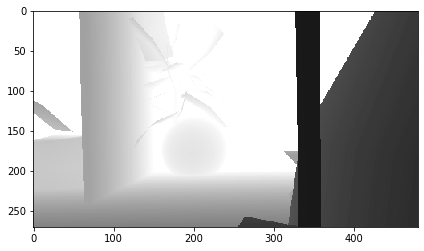

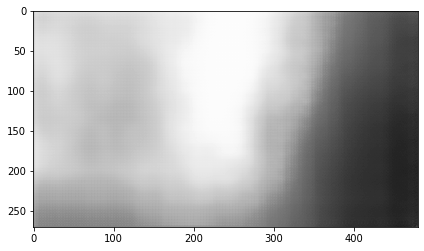

- Before encoding, mean: 0.415 var: 0.099
- After deconv 7, mean: -0.223 var: 3.030
- After sigmoid, mean: 0.435 var: 0.077
Epoch: 8/10, Step: 31/65, Avg loss: 2369.778, time: 140.53, Avg. per iter 4.35, Est. time left 148.04

- Before encoding, mean: 0.462 var: 0.126
- After deconv 7, mean: -0.011 var: 4.281
- After sigmoid, mean: 0.458 var: 0.097
Epoch: 8/10, Step: 32/65, Avg loss: 2377.637, time: 144.95, Avg. per iter 4.35, Est. time left 143.69

- Before encoding, mean: 0.419 var: 0.107
- After deconv 7, mean: -0.330 var: 3.844
- After sigmoid, mean: 0.410 var: 0.090
Epoch: 8/10, Step: 33/65, Avg loss: 2379.946, time: 149.46, Avg. per iter 4.35, Est. time left 139.35

- Before encoding, mean: 0.524 var: 0.132
- After deconv 7, mean: 0.257 var: 5.947
- After sigmoid, mean: 0.494 var: 0.119
Epoch: 8/10, Step: 34/65, Avg loss: 2383.073, time: 153.93, Avg. per iter 4.35, Est. time left 135.00

- Before encoding, mean: 0.540 var: 0.121
- After deconv 7, mean: 0.448 var: 6.424
- After si

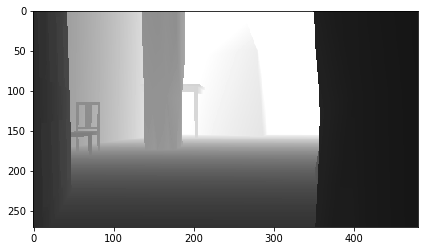

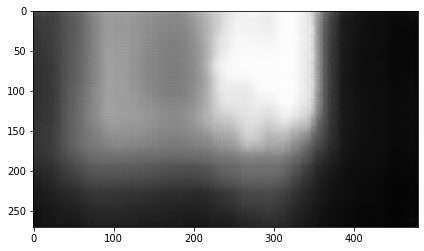

- Before encoding, mean: 0.436 var: 0.096
- After deconv 7, mean: -0.312 var: 3.116
- After sigmoid, mean: 0.419 var: 0.075
Epoch: 8/10, Step: 41/65, Avg loss: 2377.141, time: 185.85, Avg. per iter 4.36, Est. time left 104.57

- Before encoding, mean: 0.457 var: 0.126
- After deconv 7, mean: 0.102 var: 4.200
- After sigmoid, mean: 0.471 var: 0.092
Epoch: 8/10, Step: 42/65, Avg loss: 2390.070, time: 190.44, Avg. per iter 4.36, Est. time left 100.23

- Before encoding, mean: 0.402 var: 0.117
- After deconv 7, mean: -0.027 var: 3.777
- After sigmoid, mean: 0.449 var: 0.089
Epoch: 8/10, Step: 43/65, Avg loss: 2389.313, time: 194.94, Avg. per iter 4.36, Est. time left 95.88

- Before encoding, mean: 0.402 var: 0.110
- After deconv 7, mean: -0.119 var: 4.114
- After sigmoid, mean: 0.435 var: 0.092
Epoch: 8/10, Step: 44/65, Avg loss: 2391.935, time: 199.97, Avg. per iter 4.36, Est. time left 91.55

- Before encoding, mean: 0.432 var: 0.106
- After deconv 7, mean: -0.309 var: 4.894
- After sig

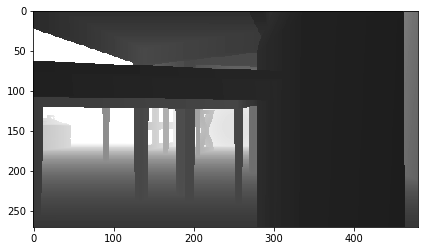

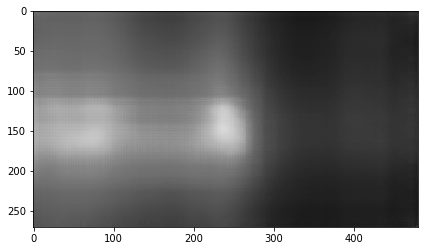

- Before encoding, mean: 0.500 var: 0.124
- After deconv 7, mean: 0.174 var: 4.586
- After sigmoid, mean: 0.484 var: 0.099
Epoch: 8/10, Step: 51/65, Avg loss: 2416.570, time: 231.41, Avg. per iter 4.36, Est. time left 61.05

- Before encoding, mean: 0.471 var: 0.102
- After deconv 7, mean: -0.163 var: 3.814
- After sigmoid, mean: 0.440 var: 0.083
Epoch: 8/10, Step: 52/65, Avg loss: 2414.103, time: 236.16, Avg. per iter 4.36, Est. time left 56.70

- Before encoding, mean: 0.449 var: 0.098
- After deconv 7, mean: -0.251 var: 3.300
- After sigmoid, mean: 0.430 var: 0.080
Epoch: 8/10, Step: 53/65, Avg loss: 2415.759, time: 240.84, Avg. per iter 4.36, Est. time left 52.35

- Before encoding, mean: 0.438 var: 0.114
- After deconv 7, mean: -0.065 var: 3.880
- After sigmoid, mean: 0.449 var: 0.090
Epoch: 8/10, Step: 54/65, Avg loss: 2417.246, time: 245.20, Avg. per iter 4.36, Est. time left 47.98

- Before encoding, mean: 0.468 var: 0.131
- After deconv 7, mean: 0.196 var: 4.887
- After sigmoi

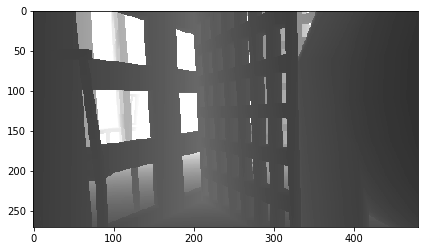

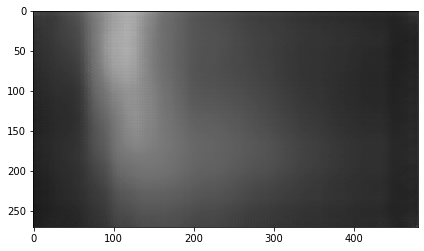

- Before encoding, mean: 0.434 var: 0.097
- After deconv 7, mean: -0.282 var: 3.871
- After sigmoid, mean: 0.424 var: 0.086
Epoch: 8/10, Step: 61/65, Avg loss: 2397.039, time: 276.47, Avg. per iter 4.36, Est. time left 17.45

- Before encoding, mean: 0.436 var: 0.102
- After deconv 7, mean: -0.111 var: 3.553
- After sigmoid, mean: 0.448 var: 0.086
Epoch: 8/10, Step: 62/65, Avg loss: 2394.255, time: 280.78, Avg. per iter 4.36, Est. time left 13.09

- Before encoding, mean: 0.484 var: 0.107
- After deconv 7, mean: 0.205 var: 3.750
- After sigmoid, mean: 0.491 var: 0.084
Epoch: 8/10, Step: 63/65, Avg loss: 2393.193, time: 284.91, Avg. per iter 4.36, Est. time left 8.73

- Before encoding, mean: 0.389 var: 0.090
- After deconv 7, mean: -0.150 var: 2.580
- After sigmoid, mean: 0.437 var: 0.066
Epoch: 8/10, Step: 64/65, Avg loss: 2391.910, time: 289.12, Avg. per iter 4.36, Est. time left 4.36

- Before encoding, mean: 0.462 var: 0.101
- After deconv 7, mean: -0.056 var: 3.043
- After sigmoid

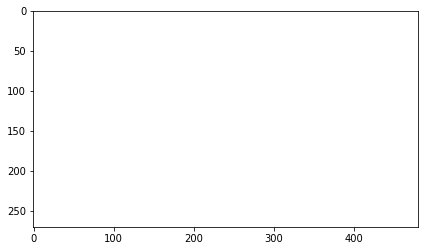

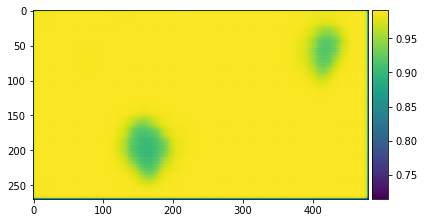

- Before encoding, mean: 0.408 var: 0.125
- After deconv 7, mean: -0.156 var: 4.057
- After sigmoid, mean: 0.426 var: 0.094
Epoch: 9/10, Step: 11/65, Avg loss: 2171.002, time: 47.89, Avg. per iter 4.36, Est. time left 235.40

- Before encoding, mean: 0.385 var: 0.101
- After deconv 7, mean: -0.540 var: 3.656
- After sigmoid, mean: 0.372 var: 0.079
Epoch: 9/10, Step: 12/65, Avg loss: 2223.765, time: 52.05, Avg. per iter 4.36, Est. time left 231.02

- Before encoding, mean: 0.459 var: 0.109
- After deconv 7, mean: -0.495 var: 5.198
- After sigmoid, mean: 0.406 var: 0.101
Epoch: 9/10, Step: 13/65, Avg loss: 2247.007, time: 56.49, Avg. per iter 4.36, Est. time left 226.67

- Before encoding, mean: 0.493 var: 0.114
- After deconv 7, mean: -0.107 var: 5.925
- After sigmoid, mean: 0.459 var: 0.112
Epoch: 9/10, Step: 14/65, Avg loss: 2291.978, time: 60.63, Avg. per iter 4.36, Est. time left 222.29

- Before encoding, mean: 0.417 var: 0.107
- After deconv 7, mean: -0.181 var: 4.901
- After sigm

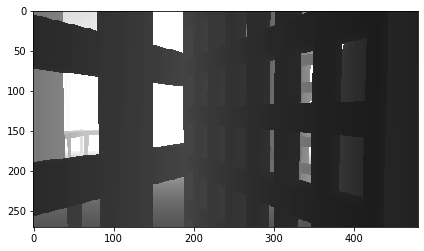

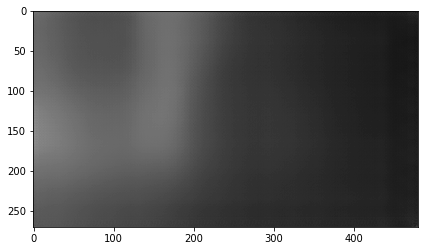

- Before encoding, mean: 0.446 var: 0.114
- After deconv 7, mean: -0.072 var: 3.952
- After sigmoid, mean: 0.446 var: 0.088
Epoch: 9/10, Step: 21/65, Avg loss: 2271.834, time: 89.89, Avg. per iter 4.36, Est. time left 191.66

- Before encoding, mean: 0.420 var: 0.094
- After deconv 7, mean: -0.117 var: 3.754
- After sigmoid, mean: 0.434 var: 0.087
Epoch: 9/10, Step: 22/65, Avg loss: 2255.602, time: 94.07, Avg. per iter 4.36, Est. time left 187.29

- Before encoding, mean: 0.507 var: 0.116
- After deconv 7, mean: 0.462 var: 5.578
- After sigmoid, mean: 0.517 var: 0.109
Epoch: 9/10, Step: 23/65, Avg loss: 2235.574, time: 98.25, Avg. per iter 4.36, Est. time left 182.92

- Before encoding, mean: 0.417 var: 0.105
- After deconv 7, mean: -0.122 var: 4.384
- After sigmoid, mean: 0.434 var: 0.095
Epoch: 9/10, Step: 24/65, Avg loss: 2232.692, time: 102.81, Avg. per iter 4.36, Est. time left 178.58

- Before encoding, mean: 0.418 var: 0.102
- After deconv 7, mean: -0.233 var: 4.509
- After sigm

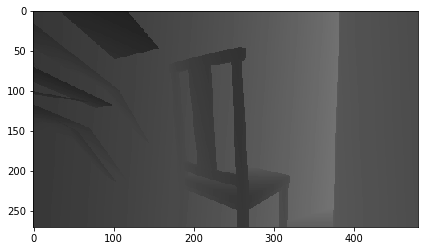

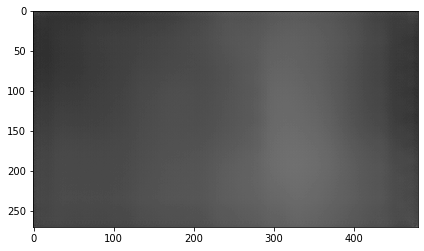

- Before encoding, mean: 0.495 var: 0.113
- After deconv 7, mean: 0.184 var: 4.430
- After sigmoid, mean: 0.493 var: 0.094
Epoch: 9/10, Step: 31/65, Avg loss: 2196.960, time: 134.49, Avg. per iter 4.36, Est. time left 148.15

- Before encoding, mean: 0.502 var: 0.120
- After deconv 7, mean: 0.181 var: 4.310
- After sigmoid, mean: 0.499 var: 0.096
Epoch: 9/10, Step: 32/65, Avg loss: 2224.066, time: 139.10, Avg. per iter 4.36, Est. time left 143.81

- Before encoding, mean: 0.494 var: 0.119
- After deconv 7, mean: 0.170 var: 5.053
- After sigmoid, mean: 0.487 var: 0.104
Epoch: 9/10, Step: 33/65, Avg loss: 2225.475, time: 143.77, Avg. per iter 4.36, Est. time left 139.47

- Before encoding, mean: 0.433 var: 0.100
- After deconv 7, mean: -0.266 var: 3.768
- After sigmoid, mean: 0.428 var: 0.086
Epoch: 9/10, Step: 34/65, Avg loss: 2234.119, time: 148.04, Avg. per iter 4.36, Est. time left 135.11

- Before encoding, mean: 0.433 var: 0.123
- After deconv 7, mean: -0.112 var: 4.686
- After sig

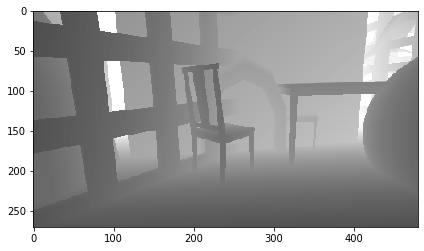

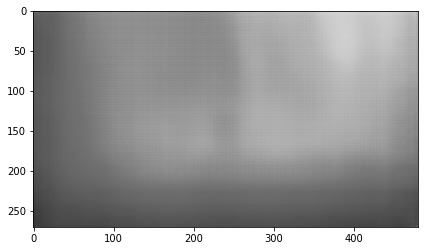

- Before encoding, mean: 0.429 var: 0.123
- After deconv 7, mean: 0.087 var: 4.844
- After sigmoid, mean: 0.458 var: 0.100
Epoch: 9/10, Step: 41/65, Avg loss: 2220.228, time: 180.11, Avg. per iter 4.36, Est. time left 104.66

- Before encoding, mean: 0.431 var: 0.096
- After deconv 7, mean: -0.206 var: 3.896
- After sigmoid, mean: 0.425 var: 0.088
Epoch: 9/10, Step: 42/65, Avg loss: 2213.723, time: 184.50, Avg. per iter 4.36, Est. time left 100.30

- Before encoding, mean: 0.356 var: 0.091
- After deconv 7, mean: -0.572 var: 3.235
- After sigmoid, mean: 0.372 var: 0.078
Epoch: 9/10, Step: 43/65, Avg loss: 2209.606, time: 188.87, Avg. per iter 4.36, Est. time left 95.94

- Before encoding, mean: 0.435 var: 0.099
- After deconv 7, mean: -0.425 var: 4.221
- After sigmoid, mean: 0.397 var: 0.088
Epoch: 9/10, Step: 44/65, Avg loss: 2223.297, time: 193.21, Avg. per iter 4.36, Est. time left 91.58

- Before encoding, mean: 0.443 var: 0.086
- After deconv 7, mean: -0.430 var: 3.444
- After sig

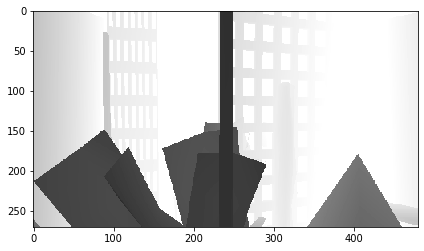

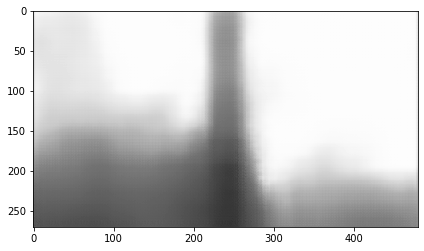

- Before encoding, mean: 0.441 var: 0.117
- After deconv 7, mean: -0.340 var: 5.601
- After sigmoid, mean: 0.409 var: 0.112
Epoch: 9/10, Step: 51/65, Avg loss: 2218.965, time: 224.52, Avg. per iter 4.36, Est. time left 61.06

- Before encoding, mean: 0.424 var: 0.101
- After deconv 7, mean: -0.293 var: 4.265
- After sigmoid, mean: 0.415 var: 0.092
Epoch: 9/10, Step: 52/65, Avg loss: 2229.157, time: 228.71, Avg. per iter 4.36, Est. time left 56.70

- Before encoding, mean: 0.442 var: 0.115
- After deconv 7, mean: 0.093 var: 5.272
- After sigmoid, mean: 0.465 var: 0.104
Epoch: 9/10, Step: 53/65, Avg loss: 2221.546, time: 232.88, Avg. per iter 4.36, Est. time left 52.33

- Before encoding, mean: 0.450 var: 0.114
- After deconv 7, mean: 0.143 var: 4.715
- After sigmoid, mean: 0.476 var: 0.099
Epoch: 9/10, Step: 54/65, Avg loss: 2223.499, time: 237.06, Avg. per iter 4.36, Est. time left 47.97

- Before encoding, mean: 0.438 var: 0.100
- After deconv 7, mean: -0.119 var: 3.620
- After sigmoi

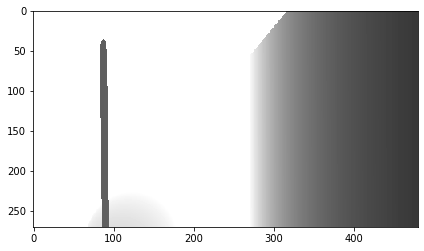

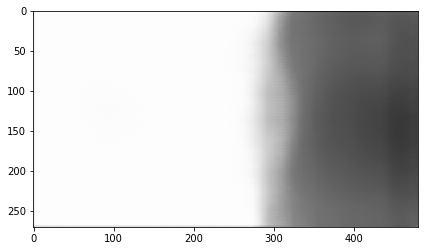

- Before encoding, mean: 0.496 var: 0.104
- After deconv 7, mean: 0.147 var: 4.251
- After sigmoid, mean: 0.492 var: 0.094
Epoch: 9/10, Step: 61/65, Avg loss: 2221.882, time: 266.94, Avg. per iter 4.36, Est. time left 17.44

- Before encoding, mean: 0.467 var: 0.097
- After deconv 7, mean: -0.021 var: 4.110
- After sigmoid, mean: 0.463 var: 0.090
Epoch: 9/10, Step: 62/65, Avg loss: 2226.231, time: 271.97, Avg. per iter 4.36, Est. time left 13.08

- Before encoding, mean: 0.441 var: 0.114
- After deconv 7, mean: -0.008 var: 5.132
- After sigmoid, mean: 0.450 var: 0.105
Epoch: 9/10, Step: 63/65, Avg loss: 2219.996, time: 277.08, Avg. per iter 4.36, Est. time left 8.72

- Before encoding, mean: 0.421 var: 0.111
- After deconv 7, mean: -0.154 var: 4.446
- After sigmoid, mean: 0.432 var: 0.096
Epoch: 9/10, Step: 64/65, Avg loss: 2219.123, time: 282.44, Avg. per iter 4.36, Est. time left 4.36

- Before encoding, mean: 0.537 var: 0.110
- After deconv 7, mean: 0.271 var: 4.546
- After sigmoid,

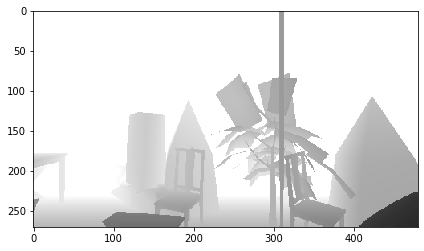

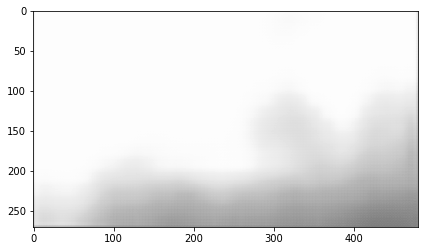

- Before encoding, mean: 0.504 var: 0.115
- After deconv 7, mean: 0.413 var: 5.412
- After sigmoid, mean: 0.516 var: 0.103
Epoch: 10/10, Step: 11/65, Avg loss: 2051.246, time: 46.98, Avg. per iter 4.36, Est. time left 235.39

- Before encoding, mean: 0.397 var: 0.106
- After deconv 7, mean: -0.351 var: 4.119
- After sigmoid, mean: 0.407 var: 0.093
Epoch: 10/10, Step: 12/65, Avg loss: 2060.821, time: 51.17, Avg. per iter 4.36, Est. time left 231.01

- Before encoding, mean: 0.442 var: 0.118
- After deconv 7, mean: -0.247 var: 5.209
- After sigmoid, mean: 0.418 var: 0.103
Epoch: 10/10, Step: 13/65, Avg loss: 2093.512, time: 55.23, Avg. per iter 4.36, Est. time left 226.63

- Before encoding, mean: 0.380 var: 0.096
- After deconv 7, mean: -0.596 var: 4.213
- After sigmoid, mean: 0.367 var: 0.090
Epoch: 10/10, Step: 14/65, Avg loss: 2048.288, time: 59.37, Avg. per iter 4.36, Est. time left 222.25

- Before encoding, mean: 0.454 var: 0.118
- After deconv 7, mean: -0.142 var: 4.746
- After s

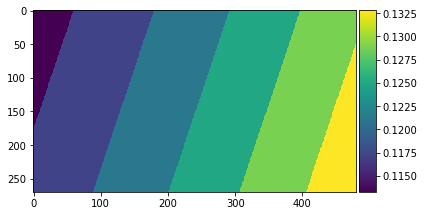

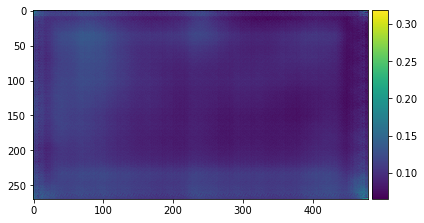

- Before encoding, mean: 0.503 var: 0.129
- After deconv 7, mean: 0.403 var: 6.445
- After sigmoid, mean: 0.497 var: 0.120
Epoch: 10/10, Step: 21/65, Avg loss: 1998.762, time: 90.07, Avg. per iter 4.36, Est. time left 191.73

- Before encoding, mean: 0.411 var: 0.114
- After deconv 7, mean: -0.106 var: 4.346
- After sigmoid, mean: 0.437 var: 0.095
Epoch: 10/10, Step: 22/65, Avg loss: 2017.535, time: 94.16, Avg. per iter 4.36, Est. time left 187.36

- Before encoding, mean: 0.388 var: 0.093
- After deconv 7, mean: -0.310 var: 3.739
- After sigmoid, mean: 0.411 var: 0.079
Epoch: 10/10, Step: 23/65, Avg loss: 2034.189, time: 98.35, Avg. per iter 4.36, Est. time left 182.99

- Before encoding, mean: 0.449 var: 0.104
- After deconv 7, mean: -0.174 var: 4.370
- After sigmoid, mean: 0.437 var: 0.093
Epoch: 10/10, Step: 24/65, Avg loss: 2046.399, time: 102.51, Avg. per iter 4.36, Est. time left 178.62

- Before encoding, mean: 0.457 var: 0.094
- After deconv 7, mean: -0.272 var: 3.918
- After 

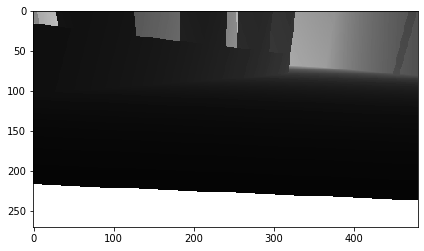

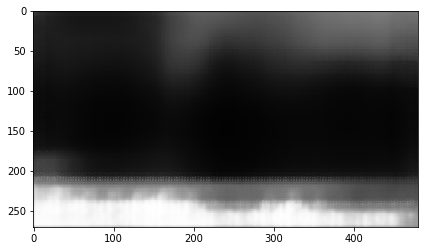

- Before encoding, mean: 0.461 var: 0.123
- After deconv 7, mean: -0.139 var: 4.847
- After sigmoid, mean: 0.432 var: 0.103
Epoch: 10/10, Step: 31/65, Avg loss: 2054.226, time: 132.22, Avg. per iter 4.35, Est. time left 148.07

- Before encoding, mean: 0.419 var: 0.104
- After deconv 7, mean: -0.309 var: 4.246
- After sigmoid, mean: 0.412 var: 0.092
Epoch: 10/10, Step: 32/65, Avg loss: 2055.143, time: 136.30, Avg. per iter 4.35, Est. time left 143.70

- Before encoding, mean: 0.452 var: 0.109
- After deconv 7, mean: 0.070 var: 5.129
- After sigmoid, mean: 0.459 var: 0.099
Epoch: 10/10, Step: 33/65, Avg loss: 2054.465, time: 140.49, Avg. per iter 4.35, Est. time left 139.33

- Before encoding, mean: 0.405 var: 0.106
- After deconv 7, mean: -0.136 var: 4.227
- After sigmoid, mean: 0.431 var: 0.091
Epoch: 10/10, Step: 34/65, Avg loss: 2064.356, time: 144.87, Avg. per iter 4.35, Est. time left 134.98

- Before encoding, mean: 0.464 var: 0.119
- After deconv 7, mean: 0.165 var: 4.947
- Afte

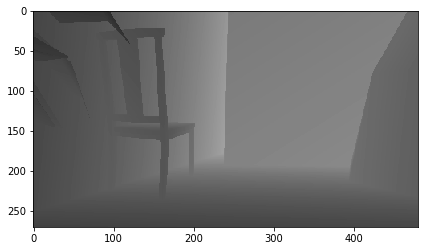

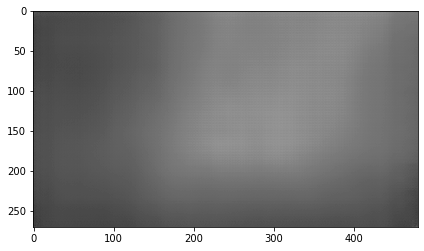

- Before encoding, mean: 0.397 var: 0.109
- After deconv 7, mean: -0.117 var: 4.042
- After sigmoid, mean: 0.433 var: 0.086
Epoch: 10/10, Step: 41/65, Avg loss: 2109.939, time: 174.93, Avg. per iter 4.35, Est. time left 104.48

- Before encoding, mean: 0.455 var: 0.095
- After deconv 7, mean: -0.237 var: 4.103
- After sigmoid, mean: 0.432 var: 0.085
Epoch: 10/10, Step: 42/65, Avg loss: 2113.906, time: 179.26, Avg. per iter 4.35, Est. time left 100.12

- Before encoding, mean: 0.423 var: 0.118
- After deconv 7, mean: -0.325 var: 5.072
- After sigmoid, mean: 0.410 var: 0.101
Epoch: 10/10, Step: 43/65, Avg loss: 2108.734, time: 183.74, Avg. per iter 4.35, Est. time left 95.78

- Before encoding, mean: 0.472 var: 0.128
- After deconv 7, mean: 0.067 var: 6.248
- After sigmoid, mean: 0.454 var: 0.122
Epoch: 10/10, Step: 44/65, Avg loss: 2100.451, time: 188.12, Avg. per iter 4.35, Est. time left 91.42

- Before encoding, mean: 0.440 var: 0.105
- After deconv 7, mean: -0.189 var: 4.825
- After

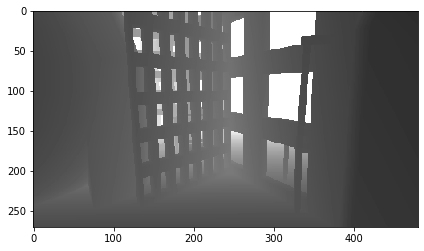

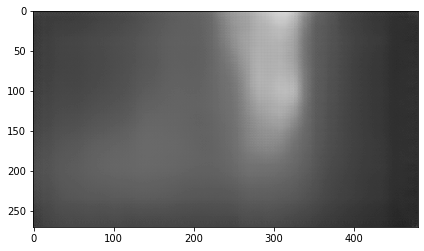

- Before encoding, mean: 0.491 var: 0.115
- After deconv 7, mean: 0.028 var: 4.405
- After sigmoid, mean: 0.471 var: 0.099
Epoch: 10/10, Step: 51/65, Avg loss: 2084.088, time: 220.55, Avg. per iter 4.36, Est. time left 60.99

- Before encoding, mean: 0.488 var: 0.134
- After deconv 7, mean: 0.349 var: 5.691
- After sigmoid, mean: 0.501 var: 0.110


In [ ]:
time_iteration = []
# train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size)
# train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
# train_loader = next(iter(train_loader))

save_model_file = "../../../vae_models/vae_dronet_sigmoid_mse"
load_model_file = "../../../vae_models/vae_dronet_nopool"

for epoch in range(num_epochs):
    overall_loss = 0
    overall_elbo = 0
    since = time.time()
    
#     train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size)
#     train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
    n_iterations = len(train_loader)
    
    for i, (image, *_) in enumerate(train_loader):
        since_iter = time.time()

        optimiser.zero_grad()

        # VAE forward pass
        x_hat, mu, logvar, z = vae_model(image)

        # Loss
        loss = mse_loss(image, x_hat, mu, logvar)

        overall_loss += loss

        # Update weights
        
        loss.backward()
        optimiser.step()
        
        
        time_iteration.append(time.time() - since_iter)
        iter_time_mean = np.array(time_iteration).mean()
        
        if (i+1) % 1 == 0:
            time_elapsed = time.time() - since
            print(f"Epoch: {epoch+1}/{num_epochs}, Step: {i+1}/{n_iterations}, Avg loss: {overall_loss/((i+1)*batch_size):.3f}, time: {time_elapsed:.2f}, Avg. per iter {iter_time_mean:.2f}, Est. time left {iter_time_mean*(n_iterations - (i+1)):.2f}")
            print()
            
        if (i+1) % 10 == 0:
            imshow(image[0])
            imshow(x_hat[0].detach())
    
    save_model_file_dir = save_model_file + f"_{epoch+1}.pth"
    torch.save(vae_model.state_dict(), save_model_file_dir)
            

# Some results

### BCE
- 10 epochs, no batch norm: 60191.195

### BCE with unpooling
- 10 epochs, clear reconstruction but image indices carried through VAE. Faster training than BCE

### ReLU + MSE loss
- Avg loss: 2629.289, very poor reconstruction

In [ ]:
torch.save(vae_model.state_dict(), save_model_file)

In [ ]:
load_model=False
if load_model:
    vae_model.load_state_dict(torch.load(load_model_file))
    vae_model.eval()
else:
    vae_model.train()

# Training Run 2

In [ ]:
# vae_model = VAE(n_z=latent_dim)

# if load_model:
#     vae_model.load_state_dict(torch.load(load_model_file))
#     vae_model.eval()
# else:
#     vae_model.train()

# optimiser = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)
# summary(vae_model, (1, 270, 480))

In [ ]:
# time_iteration = []
# # train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size)
# # train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
# # train_loader = next(iter(train_loader))

# for epoch in range(150):
#     overall_loss = 0
#     overall_elbo = 0
#     since = time.time()
    
#     train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size)
#     train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
#     n_iterations = len(train_loader)
    
#     for i, (image, *_) in enumerate(train_loader):
#         since_iter = time.time()

#         optimiser.zero_grad()

#         # VAE forward pass
#         x_hat, mu, logvar, z = vae_model(image)

#         # Loss
#         loss = mse_loss(image, x_hat, mu, logvar)

#         overall_loss += loss

#         # Update weights
        
#         loss.backward()
#         optimiser.step()
        
        
#         time_iteration.append(time.time() - since_iter)
#         iter_time_mean = np.array(time_iteration).mean()
        
#         if (i+1) % 5 == 0:
#             time_elapsed = time.time() - since
#             print(f"Epoch: {epoch+1}/{num_epochs}, Step: {i+1}/{n_iterations}, Avg loss: {overall_loss/((i+1)*batch_size):.3f}, time: {time_elapsed:.2f}, Avg. per iter {iter_time_mean:.2f}, Est. time left {iter_time_mean*(n_iterations - (i+1)):.2f}")
#             print()
#             save_model_file = f"../../../vae_models/vae_resnet_drone_net_mse_{i+1}.pth"
#             torch.save(vae_model.state_dict(), save_model_file)
            
#         if (i+1) % 50 == 0:
#             imshow(image[0])
#             imshow(x_hat[0].detach())
#             '

# Evaluation

In [ ]:
vae_model.eval()

# Visualise sample of images
with torch.no_grad():
    
    images, *_ = next(iter(test_loader))

    x_hat, *_ = vae_model.forward_test(images)

    print(images.mean(), x_hat.mean())
    print(images.var(), x_hat.var())
    print(images.shape)
    for idx in range(len(images)):
        # show images
        imshow(images[idx])
        imshow(x_hat[idx])

In [ ]:
train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size)
train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)

vae_model.eval()
# Visualise sample of images

with torch.no_grad():
        
    images, *_ = next(iter(train_loader)) # if dataset is shuffled every iter(), essentially test 
    # VAE forward pass
    x_hat, *_ = vae_model.forward_test(images)

    print(images.mean(), x_hat.mean())
    print(images.var(), x_hat.var())
    print(images.shape)
    for idx in range(len(images)):
        # show images
        imshow(images[idx])
        imshow(x_hat[idx])
